<a href="https://colab.research.google.com/github/nsyifa/fine-grain-clip/blob/main/DeepLearning_FinalProject_2023952684.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Imports

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
os

<module 'os' from '/usr/lib/python3.10/os.py'>

In [4]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

Torch version: 2.1.0+cu118


In [5]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP
!pip install -r requirements.txt

Cloning into 'CLIP'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 251 (delta 3), reused 3 (delta 0), pack-reused 243
Receiving objects: 100% (251/251), 8.93 MiB | 11.63 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/content/CLIP
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 937.3 kB/s eta 0:00:00


In [6]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 44.6MiB/s]


In [ ]:
print(device)

cuda


# Loading the dataset

We load the dataset, normalize the image pixel values to range [-1,1], and resize the images to 256 x 256 resolution..

In [50]:
import os
import pandas as pd
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
from torchvision.transforms import Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np

class CatBreedDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None, normalize=True, resize_shape=(256, 256), indices=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.classes.remove('_Readme_.txt')
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # If indices are provided, use them for the dataset
        self.images = self.make_dataset(indices) if indices else self.make_dataset()

        self.transform = transform
        self.target_transform = target_transform
        self.normalize = normalize
        self.resize = Resize(resize_shape) if resize_shape is not None else None

    def make_dataset(self, indices=None):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                label = self.class_to_idx[class_name]
                images.append((img_path, label))

        # If indices are provided, use them to subset the dataset
        if indices:
            images = [images[i] for i in indices]

        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = read_image(img_path, mode=ImageReadMode.RGB)

        if (self.resize or self.normalize or self.transform or self.target_transform):
            image = image.float()  # Convert to float for normalization

        if self.resize:
            image = self.resize(image)

        if self.normalize:
            # Assuming the images are in the range [0, 255], normalize to [0, 1]
            image /= 255.0
            image = Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(image)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)


        return image, label

In [51]:
def display_images(images, labels, classes):
        plt.figure(figsize=(15, 5))
        for i in range(len(images)):
            image_np = images[i].numpy().transpose((1, 2, 0))
            image_rescaled = (image_np + 1) / 2  # Rescale back to [0, 1] for display
            plt.subplot(1, len(images), i + 1)
            plt.imshow(image_rescaled)
            plt.title(f'Class: {classes[labels[i]]}')
            plt.axis('off')
        plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


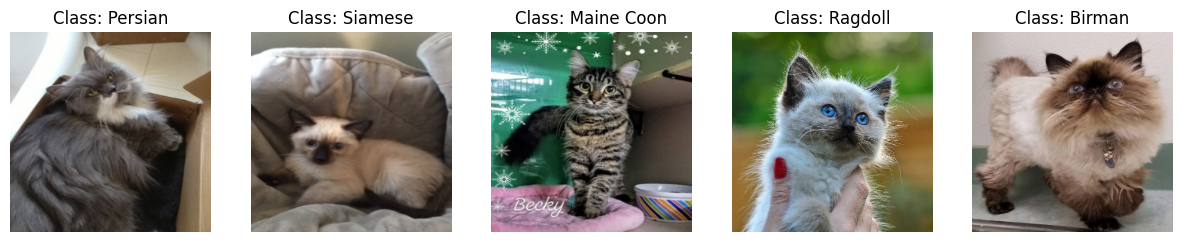

In [9]:
import random

dataset = CatBreedDataset(root_dir='/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1')
indices = random.sample(range(len(dataset)), 5)
images, labels = zip(*[dataset[i] for i in indices])
display_images(images, labels, dataset.classes)

# Getting the best class name configuration

## Data Preprocessing

Split the 5000 images into train and test. Then perform a preprocessing pipeline of normalization and data augmentation (random resize crop and horizontal flip)

In [49]:
import os
#our the classes and images we want to test are stored in folders in the test set
class_names = os.listdir('/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1/')
class_names.remove('_Readme_.txt')
class_names

['Birman',
 'Abyssinian',
 'Egyptian Mau',
 'Bombay',
 'Persian',
 'American Bobtail',
 'Bengal',
 'British Shorthair',
 'Maine Coon',
 'American Shorthair',
 'Sphynx',
 'Ragdoll',
 'Tuxedo',
 'Russian Blue',
 'Siamese']

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit
import torch
from torchvision import transforms
from torchvision.transforms import RandomResizedCrop, RandomRotation, RandomHorizontalFlip

num_images_per_class = 375

# Create labels by repeating class names
labels = [class_name for class_name in class_names for _ in range(num_images_per_class)]

# Split the dataset into training and test sets with stratified sampling
sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss_train_test.split(range(len(dataset)), labels):
    train_indices, test_indices = train_index, test_index

# Split the training set into training and validation sets with stratified sampling
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, val_index in sss_train_val.split(train_indices, [labels[i] for i in train_indices]):
    train_indices, val_indices = train_index, val_index

# Define transformations for training
train_transform = transforms.Compose([
    RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    RandomRotation(degrees=10),
    RandomHorizontalFlip(),
])

# Apply transformations to the training set
train_dataset = CatBreedDataset(root_dir='/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1', transform=train_transform, target_transform=None, normalize=True, indices=train_indices.tolist())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create the validation dataset (no augmentations)
val_dataset = CatBreedDataset(root_dir='/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1', target_transform=None, normalize=True, indices=val_indices.tolist())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create the test dataset (no augmentations)
test_dataset = CatBreedDataset(root_dir='/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1', target_transform=None, normalize=True, indices=test_indices.tolist())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

## Displaying some data

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


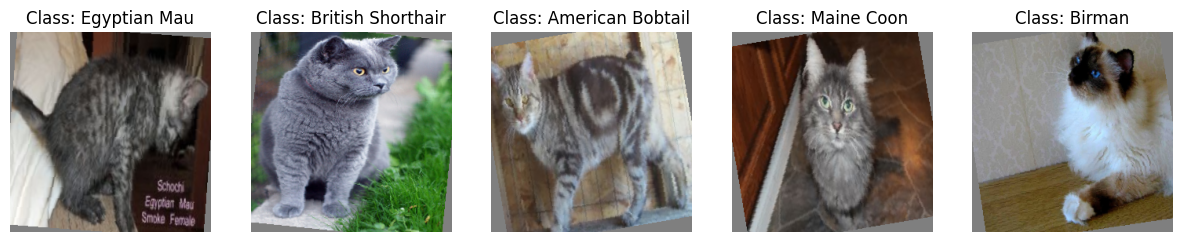

In [ ]:
indices = random.sample(range(len(train_dataset)), 5)
images, labels = zip(*[train_dataset[i] for i in indices])
display_images(images, labels, train_dataset.classes)

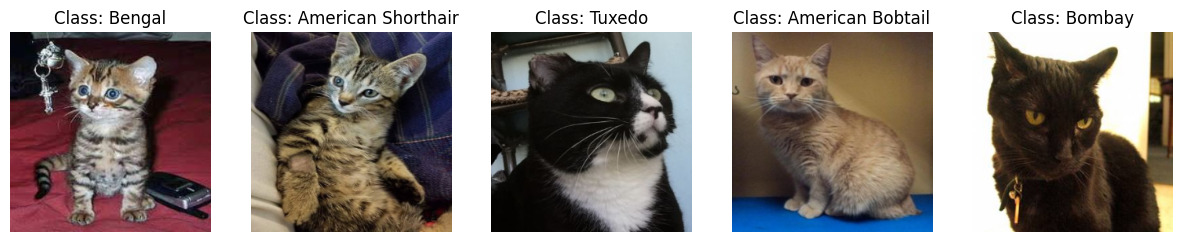

In [ ]:
indices = random.sample(range(len(test_dataset)), 5)
images, labels = zip(*[test_dataset[i] for i in indices])
display_images(images, labels, test_dataset.classes)

## Results with non-fine-tuned CLIP and original class names

In [ ]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

correct = []
correct_per_class = {}

text = clip.tokenize(class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[label] == cls:
            image = transform(transforms.ToPILImage()(image)).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')


currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.25333333333333335
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.32
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.9466666666666667
currently calculating:  Bombay
Accuracy on class Bombay is: 0.0
currently calculating:  Persian
Accuracy on class Persian is: 0.013333333333333334
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.26666666666666666
currently calculating:  Bengal
Accuracy on class Bengal is: 0.06666666666666667
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.06666666666666667
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.49333333333333335
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.0
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.5733333333333334
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.12
currently calculating:  Tuxedo
Accur

In [ ]:
correct_notune = correct.copy()
correct_per_class_notune = correct_per_class.copy()

In [ ]:
# Convert dictionary to DataFrame
df_notune = pd.DataFrame.from_dict(correct_per_class, orient='index').transpose()

# Save DataFrame to CSV
df_notune.to_csv('/content/drive/MyDrive/College/DL/Final Project/test_notune.csv', index=False)

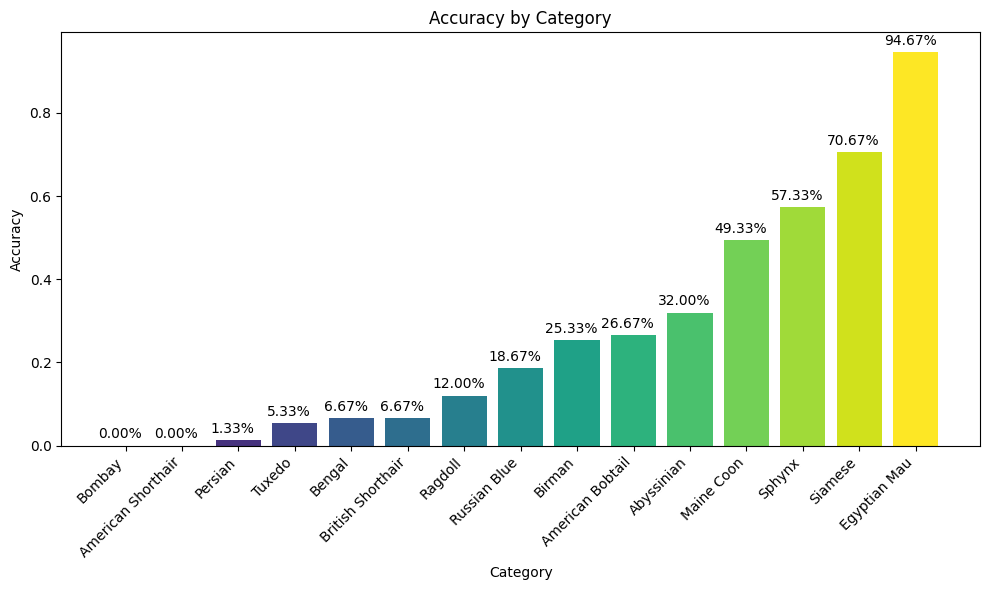

In [ ]:
# Calculate accuracy for each category
accuracies = df_notune.sum() / df_notune.apply(len)

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(accuracies)))

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.sort_values().index, accuracies.sort_values(), color=colors)
plt.title('Accuracy by Category')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

# Add labels to each bar
for bar, label in zip(bars, accuracies.sort_values()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{label:.2%}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Access correctness information per class using correct_per_class dictionary
for cls, correctness_list in correct_per_class.items():
    print(f'Accuracy on class {cls} is: {sum(correctness_list) / len(correctness_list)}')


## Results with non-fine-tuned CLIP and class names modified to a sentence (photo)
a photo of a {c} cat

In [ ]:
import os
#our the classes and images we want to test are stored in folders in the test set
mod_class_names = os.listdir('/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1/')
mod_class_names.remove('_Readme_.txt')
mod_class_names = [f"a photo of a {c} cat" for c in class_names]
mod_class_names

['a photo of a Birman cat',
 'a photo of a Abyssinian cat',
 'a photo of a Egyptian Mau cat',
 'a photo of a Bombay cat',
 'a photo of a Persian cat',
 'a photo of a American Bobtail cat',
 'a photo of a Bengal cat',
 'a photo of a British Shorthair cat',
 'a photo of a Maine Coon cat',
 'a photo of a American Shorthair cat',
 'a photo of a Sphynx cat',
 'a photo of a Ragdoll cat',
 'a photo of a Tuxedo cat',
 'a photo of a Russian Blue cat',
 'a photo of a Siamese cat']

In [ ]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

correct = []
correct_per_class = {}

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[label] == cls:
            image = transform(transforms.ToPILImage()(image)).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')


currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.12
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.30666666666666664
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.64
currently calculating:  Bombay
Accuracy on class Bombay is: 0.72
currently calculating:  Persian
Accuracy on class Persian is: 0.49333333333333335
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.30666666666666664
currently calculating:  Bengal
Accuracy on class Bengal is: 0.5733333333333334
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.14666666666666667
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.28
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.0
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.6266666666666667
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.2
currently calculating:  Tuxedo
Accuracy on class Tuxedo is: 0.24
cu

In [ ]:
correct_modsentence = correct.copy()
correct_per_class_modsentence = correct_per_class.copy()

In [ ]:
# Convert dictionary to DataFrame
df_notune_modsentence = pd.DataFrame.from_dict(correct_per_class_modsentence, orient='index').transpose()

# Save DataFrame to CSV
df_notune_modsentence.to_csv('/content/drive/MyDrive/College/DL/Final Project/test_notune_modsentence.csv', index=False)

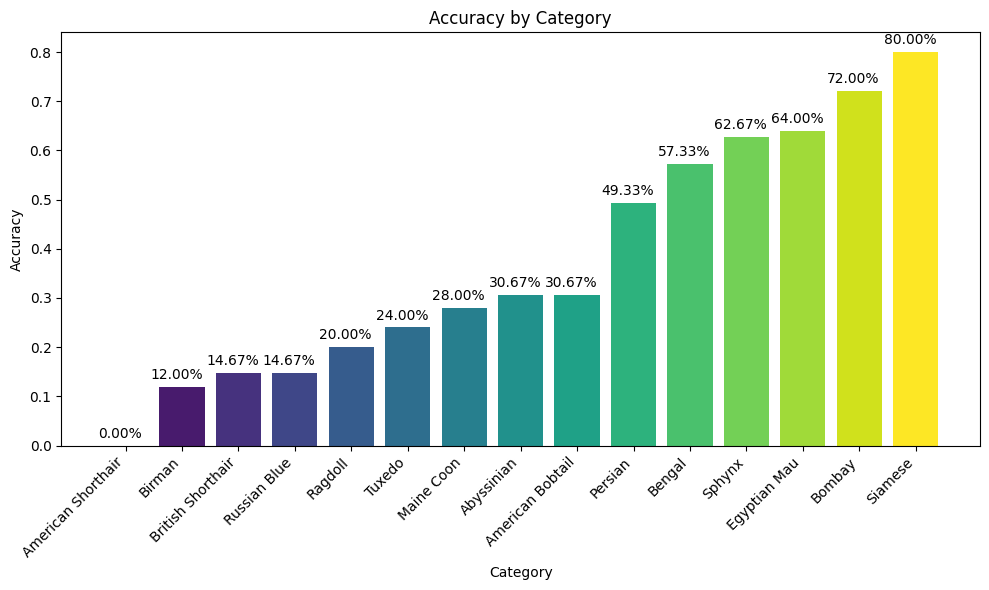

In [ ]:
# Calculate accuracy for each category
accuracies = df_notune_modsentence.sum() / df_notune.apply(len)

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(accuracies)))

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.sort_values().index, accuracies.sort_values(), color=colors)
plt.title('Accuracy by Category')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

# Add labels to each bar
for bar, label in zip(bars, accuracies.sort_values()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{label:.2%}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Access correctness information per class using correct_per_class dictionary
for cls, correctness_list in correct_per_class.items():
    print(f'Accuracy on class {cls} is: {sum(correctness_list) / len(correctness_list)}')


## Results with non-fine-tuned CLIP and class names modified to a sentence (image)
an image of a {c} cat

In [ ]:
import os
#our the classes and images we want to test are stored in folders in the test set
mod_class_names = os.listdir('/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1/')
mod_class_names.remove('_Readme_.txt')
mod_class_names = [f"an image of a {c} cat" for c in class_names]
mod_class_names

['an image of a Birman cat',
 'an image of a Abyssinian cat',
 'an image of a Egyptian Mau cat',
 'an image of a Bombay cat',
 'an image of a Persian cat',
 'an image of a American Bobtail cat',
 'an image of a Bengal cat',
 'an image of a British Shorthair cat',
 'an image of a Maine Coon cat',
 'an image of a American Shorthair cat',
 'an image of a Sphynx cat',
 'an image of a Ragdoll cat',
 'an image of a Tuxedo cat',
 'an image of a Russian Blue cat',
 'an image of a Siamese cat']

In [ ]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

correct = []
correct_per_class = {}

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[label] == cls:
            image = transform(transforms.ToPILImage()(image)).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')


currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.013333333333333334
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.32
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.5866666666666667
currently calculating:  Bombay
Accuracy on class Bombay is: 0.68
currently calculating:  Persian
Accuracy on class Persian is: 0.44
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.29333333333333333
currently calculating:  Bengal
Accuracy on class Bengal is: 0.56
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.09333333333333334
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.30666666666666664
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.0
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.64
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.44
currently calculating:  Tuxedo
Accuracy on class Tuxedo is: 0.37333333333333335

In [ ]:
correct_modsentence2 = correct.copy()
correct_per_class_modsentence2 = correct_per_class.copy()

In [ ]:
# Convert dictionary to DataFrame
df_notune_modsentence2 = pd.DataFrame.from_dict(correct_per_class_modsentence2, orient='index').transpose()

# Save DataFrame to CSV
df_notune_modsentence2.to_csv('/content/drive/MyDrive/College/DL/Final Project/test_notune_modsentence2.csv', index=False)

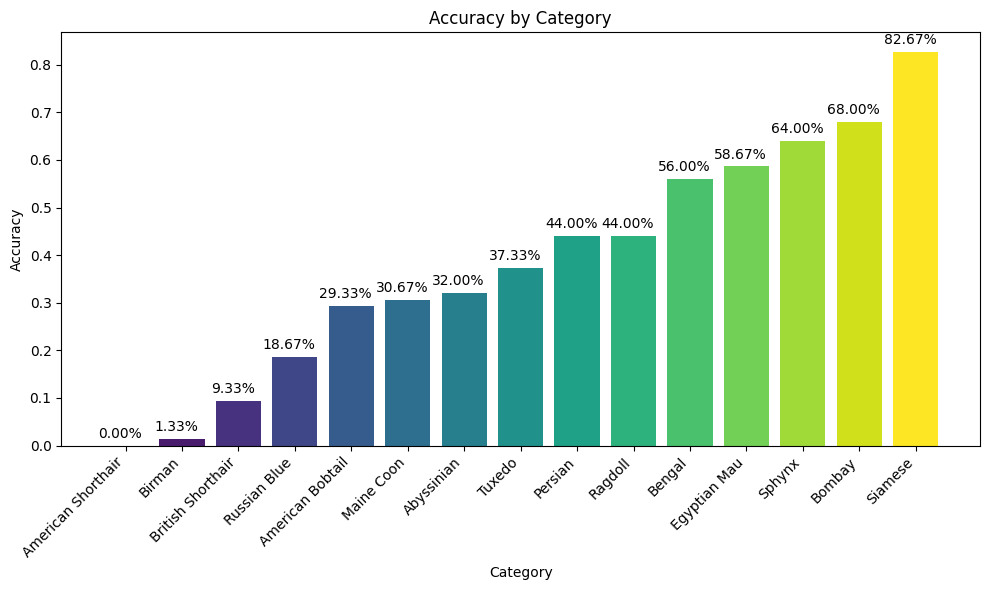

In [ ]:
# Calculate accuracy for each category
accuracies = df_notune_modsentence2.sum() / df_notune.apply(len)

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(accuracies)))

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.sort_values().index, accuracies.sort_values(), color=colors)
plt.title('Accuracy by Category')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

# Add labels to each bar
for bar, label in zip(bars, accuracies.sort_values()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{label:.2%}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

## Results with non-fine-tuned CLIP and class names modified to a sentence (picture)
a picture of a {c} cat

In [ ]:
import os
#our the classes and images we want to test are stored in folders in the test set
mod_class_names = os.listdir('/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1/')
mod_class_names.remove('_Readme_.txt')
mod_class_names = [f"a picture of a {c} cat" for c in class_names]
mod_class_names

['a picture of a Birman cat',
 'a picture of a Abyssinian cat',
 'a picture of a Egyptian Mau cat',
 'a picture of a Bombay cat',
 'a picture of a Persian cat',
 'a picture of a American Bobtail cat',
 'a picture of a Bengal cat',
 'a picture of a British Shorthair cat',
 'a picture of a Maine Coon cat',
 'a picture of a American Shorthair cat',
 'a picture of a Sphynx cat',
 'a picture of a Ragdoll cat',
 'a picture of a Tuxedo cat',
 'a picture of a Russian Blue cat',
 'a picture of a Siamese cat']

In [ ]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

correct = []
correct_per_class = {}

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[label] == cls:
            image = transform(transforms.ToPILImage()(image)).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')


currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.06666666666666667
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.30666666666666664
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.6266666666666667
currently calculating:  Bombay
Accuracy on class Bombay is: 0.6533333333333333
currently calculating:  Persian
Accuracy on class Persian is: 0.4666666666666667
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.26666666666666666
currently calculating:  Bengal
Accuracy on class Bengal is: 0.5466666666666666
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.12
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.36
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.0
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.6533333333333333
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.26666666666666666
currently calculating:  

In [ ]:
correct_modsentence3 = correct.copy()
correct_per_class_modsentence3 = correct_per_class.copy()

In [ ]:
# Convert dictionary to DataFrame
df_notune_modsentence3 = pd.DataFrame.from_dict(correct_per_class_modsentence3, orient='index').transpose()

# Save DataFrame to CSV
df_notune_modsentence3.to_csv('/content/drive/MyDrive/College/DL/Final Project/test_notune_modsentence3.csv', index=False)

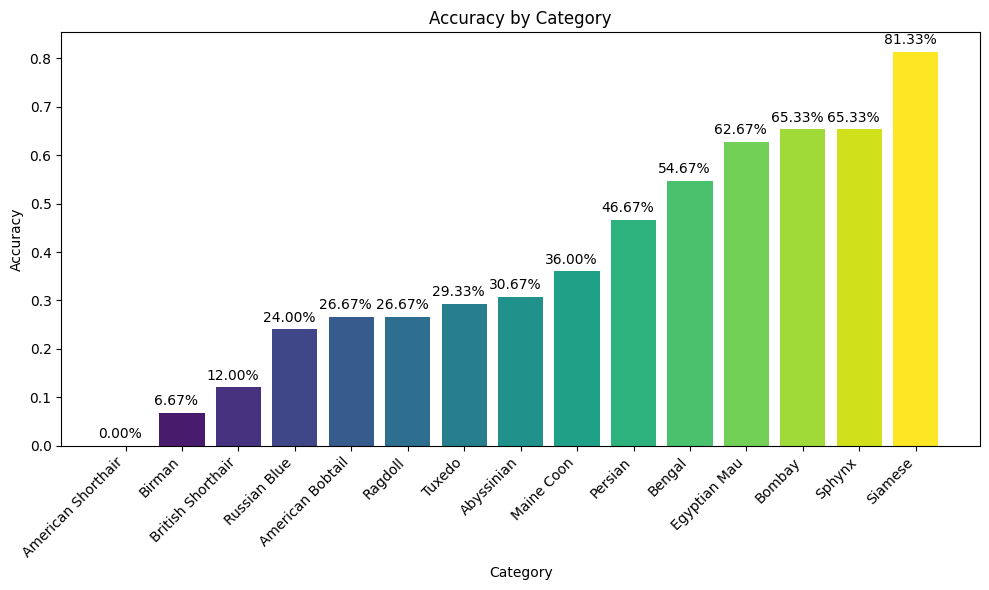

In [ ]:
# Calculate accuracy for each category
accuracies = df_notune_modsentence3.sum() / df_notune.apply(len)

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(accuracies)))

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.sort_values().index, accuracies.sort_values(), color=colors)
plt.title('Accuracy by Category')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

# Add labels to each bar
for bar, label in zip(bars, accuracies.sort_values()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{label:.2%}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

## Results with non-fine-tuned CLIP and class names modified to a phrase (without a)
{c} cat

In [ ]:
import os
#our the classes and images we want to test are stored in folders in the test set
mod_class_names = os.listdir('/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1/')
mod_class_names.remove('_Readme_.txt')
mod_class_names = [f"{c} cat" for c in class_names]
mod_class_names

['Birman cat',
 'Abyssinian cat',
 'Egyptian Mau cat',
 'Bombay cat',
 'Persian cat',
 'American Bobtail cat',
 'Bengal cat',
 'British Shorthair cat',
 'Maine Coon cat',
 'American Shorthair cat',
 'Sphynx cat',
 'Ragdoll cat',
 'Tuxedo cat',
 'Russian Blue cat',
 'Siamese cat']

In [ ]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

correct = []
correct_per_class = {}

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[label] == cls:
            image = transform(transforms.ToPILImage()(image)).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')


currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.06666666666666667
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.25333333333333335
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.6533333333333333
currently calculating:  Bombay
Accuracy on class Bombay is: 0.72
currently calculating:  Persian
Accuracy on class Persian is: 0.7066666666666667
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.25333333333333335
currently calculating:  Bengal
Accuracy on class Bengal is: 0.4666666666666667
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.04
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.17333333333333334
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.0
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.56
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.14666666666666667
currently calculating:  Tuxedo
Accura

In [ ]:
correct_modphrase = correct.copy()
correct_per_class_modphrase = correct_per_class.copy()

In [ ]:
# Convert dictionary to DataFrame
df_notune_modphrase = pd.DataFrame.from_dict(correct_per_class_modphrase, orient='index').transpose()

# Save DataFrame to CSV
df_notune_modphrase.to_csv('/content/drive/MyDrive/College/DL/Final Project/test_notune_modphrase1.csv', index=False)

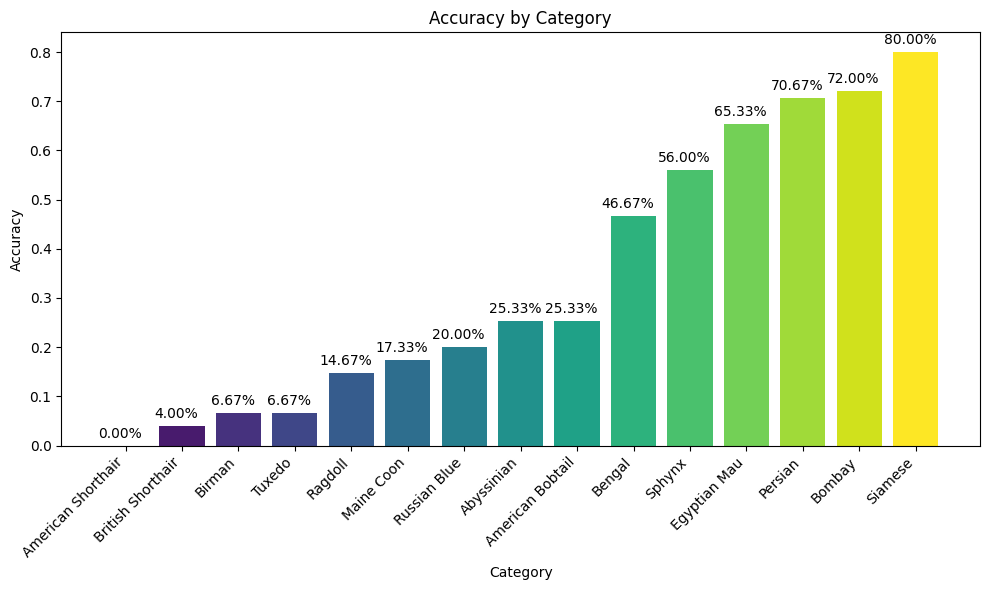

In [ ]:
# Calculate accuracy for each category
accuracies = df_notune_modphrase.sum() / df_notune.apply(len)

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(accuracies)))

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.sort_values().index, accuracies.sort_values(), color=colors)
plt.title('Accuracy by Category')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

# Add labels to each bar
for bar, label in zip(bars, accuracies.sort_values()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{label:.2%}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Access correctness information per class using correct_per_class dictionary
for cls, correctness_list in correct_per_class.items():
    print(f'Accuracy on class {cls} is: {sum(correctness_list) / len(correctness_list)}')


## Results with non-fine-tuned CLIP and class names modified to a phrase (with a)
a {c} cat

In [ ]:
import os
#our the classes and images we want to test are stored in folders in the test set
mod_class_names = os.listdir('/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1/')
mod_class_names.remove('_Readme_.txt')
mod_class_names = [f"a {c} cat" for c in class_names]
mod_class_names

['a Birman cat',
 'a Abyssinian cat',
 'a Egyptian Mau cat',
 'a Bombay cat',
 'a Persian cat',
 'a American Bobtail cat',
 'a Bengal cat',
 'a British Shorthair cat',
 'a Maine Coon cat',
 'a American Shorthair cat',
 'a Sphynx cat',
 'a Ragdoll cat',
 'a Tuxedo cat',
 'a Russian Blue cat',
 'a Siamese cat']

In [ ]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

correct = []
correct_per_class = {}

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[label] == cls:
            image = transform(transforms.ToPILImage()(image)).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')


currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.13333333333333333
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.32
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.6666666666666666
currently calculating:  Bombay
Accuracy on class Bombay is: 0.68
currently calculating:  Persian
Accuracy on class Persian is: 0.64
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.24
currently calculating:  Bengal
Accuracy on class Bengal is: 0.41333333333333333
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.10666666666666667
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.24
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.0
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.6266666666666667
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.10666666666666667
currently calculating:  Tuxedo
Accuracy on class Tuxedo is: 0.1733

In [ ]:
correct_modphrase2 = correct.copy()
correct_per_class_modphrase2 = correct_per_class.copy()

In [ ]:
# Convert dictionary to DataFrame
df_notune_modphrase2 = pd.DataFrame.from_dict(correct_per_class_modphrase2, orient='index').transpose()

# Save DataFrame to CSV
df_notune_modphrase2.to_csv('/content/drive/MyDrive/College/DL/Final Project/test_notune_modphrase2.csv', index=False)

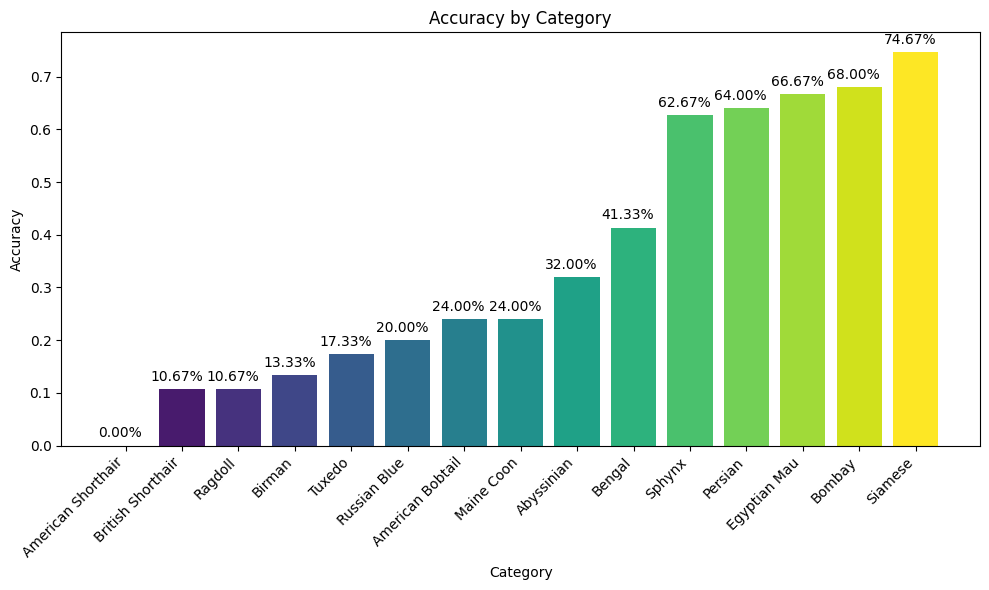

In [ ]:
# Calculate accuracy for each category
accuracies = df_notune_modphrase2.sum() / df_notune.apply(len)

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(accuracies)))

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.sort_values().index, accuracies.sort_values(), color=colors)
plt.title('Accuracy by Category')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

# Add labels to each bar
for bar, label in zip(bars, accuracies.sort_values()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{label:.2%}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

## Combining the non-tuned results
The best results come from the class names being modified into 'an image of a {breed} cat'

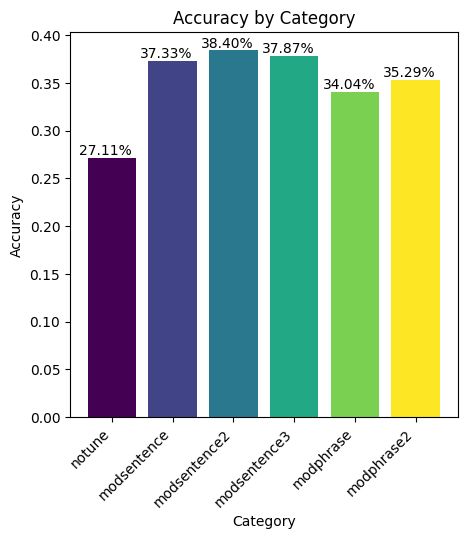

In [ ]:
# Calculate the total accuracy for each result
correct_list = [correct_notune, correct_modsentence, correct_modsentence2, correct_modsentence3, correct_modphrase, correct_modphrase2]
correct_list_name = ["notune", "modsentence", "modsentence2", "modsentence3", "modphrase", "modphrase2"]
accuracies = [sum(correct)/len(correct) for correct in correct_list]

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(accuracies)))

# Plotting
plt.figure(figsize=(5, 5))
bars = plt.bar(correct_list_name, accuracies, color=colors)
plt.title('Accuracy by Category')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')

# Add labels to each bar
for bar, label in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height(), f'{label:.2%}', ha='center', va='bottom')

# Show the plot
plt.show()

In [ ]:
# List of DataFrames
dfs = ["df_notune", "df_notune_modsentence","df_notune_modsentence2","df_notune_modsentence3", "df_notune_modphrase", "df_notune_modphrase2"]
df_notune_comb = pd.DataFrame(index=class_names, columns=dfs)
# Convert DataFrame values to numeric explicitly
df_notune_comb = df_notune_comb.apply(pd.to_numeric, errors='coerce')
for cls in class_names:
  df_notune_comb.at[cls,dfs[0]] = sum(correct_per_class_notune[cls]) / len(correct_per_class_notune[cls])
  df_notune_comb.at[cls,dfs[1]] = sum(correct_per_class_modsentence[cls]) / len(correct_per_class_modsentence[cls])
  df_notune_comb.at[cls,dfs[2]] = sum(correct_per_class_modsentence2[cls]) / len(correct_per_class_modsentence2[cls])
  df_notune_comb.at[cls,dfs[3]] = sum(correct_per_class_modsentence3[cls]) / len(correct_per_class_modsentence3[cls])
  df_notune_comb.at[cls,dfs[4]] = sum(correct_per_class_modphrase[cls]) / len(correct_per_class_modphrase[cls])
  df_notune_comb.at[cls,dfs[5]] = sum(correct_per_class_modphrase2[cls]) / len(correct_per_class_modphrase2[cls])

In [ ]:
df_notune_comb

df_notune  df_notune_modsentence  df_notune_modsentence2  \
Birman               0.253333               0.120000                0.013333   
Abyssinian           0.320000               0.306667                0.320000   
Egyptian Mau         0.946667               0.640000                0.586667   
Bombay               0.000000               0.720000                0.680000   
Persian              0.013333               0.493333                0.440000   
American Bobtail     0.266667               0.306667                0.293333   
Bengal               0.066667               0.573333                0.560000   
British Shorthair    0.066667               0.146667                0.093333   
Maine Coon           0.493333               0.280000                0.306667   
American Shorthair   0.000000               0.000000                0.000000   
Sphynx               0.573333               0.626667                0.640000   
Ragdoll              0.120000               0.200000                0.440000   
Tuxedo               0.053333               0.240000                0.373333   
Russian Blue         0.186667               0.146667                0.186667   
Siamese              0.706667               0.800000                0.826667   

                    df_notune_modsentence3  df_notune_modphrase  \
Birman                            0.066667             0.066667   
Abyssinian                        0.306667             0.253333   
Egyptian Mau                      0.626667             0.653333   
Bombay                            0.653333             0.720000   
Persian                           0.466667             0.706667   
American Bobtail                  0.266667             0.253333   
Bengal                            0.546667             0.466667   
British Shorthair                 0.120000             0.040000   
Maine Coon                        0.360000             0.173333   
American Shorthair                0.000000             0.000000   
Sphynx                            0.653333             0.560000   
Ragdoll                           0.266667             0.146667   
Tuxedo                            0.293333             0.066667   
Russian Blue                      0.240000             0.200000   
Siamese                           0.813333             0.800000   

                    df_notune_modphrase2  
Birman                          0.133333  
Abyssinian                      0.320000  
Egyptian Mau                    0.666667  
Bombay                          0.680000  
Persian                         0.640000  
American Bobtail                0.240000  
Bengal                          0.413333  
British Shorthair               0.106667  
Maine Coon                      0.240000  
American Shorthair              0.000000  
Sphynx                          0.626667  
Ragdoll                         0.106667  
Tuxedo                          0.173333  
Russian Blue                    0.200000  
Siamese                         0.746667

In [ ]:
max_column_names = df_notune_comb.idxmax(axis=1)
max_column_names

Birman                             df_notune
Abyssinian                         df_notune
Egyptian Mau                       df_notune
Bombay                 df_notune_modsentence
Persian                  df_notune_modphrase
American Bobtail       df_notune_modsentence
Bengal                 df_notune_modsentence
British Shorthair      df_notune_modsentence
Maine Coon                         df_notune
American Shorthair                 df_notune
Sphynx                df_notune_modsentence3
Ragdoll               df_notune_modsentence2
Tuxedo                df_notune_modsentence2
Russian Blue          df_notune_modsentence3
Siamese               df_notune_modsentence2
dtype: object

# Training test

In [57]:
def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

In [58]:
import os
#our the classes and images we want to test are stored in folders in the test set
class_names = os.listdir('/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1/')
class_names.remove('_Readme_.txt')
class_names

['Birman',
 'Abyssinian',
 'Egyptian Mau',
 'Bombay',
 'Persian',
 'American Bobtail',
 'Bengal',
 'British Shorthair',
 'Maine Coon',
 'American Shorthair',
 'Sphynx',
 'Ragdoll',
 'Tuxedo',
 'Russian Blue',
 'Siamese']

In [66]:
import os
import pandas as pd
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
from torchvision.transforms import Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np

class CatBreedDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None, normalize=True, resize_shape=(256, 256), indices=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.classes.remove('_Readme_.txt')
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # If indices are provided, use them for the dataset
        self.images = self.make_dataset(indices) if indices else self.make_dataset()

        self.transform = transform
        self.target_transform = target_transform
        self.normalize = normalize
        self.resize = Resize(resize_shape) if resize_shape is not None else None

    def make_dataset(self, indices=None):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                # label = self.class_to_idx[class_name]
                label = f"an image of a {class_name} cat"
                images.append((img_path, label))

        # If indices are provided, use them to subset the dataset
        if indices:
            images = [images[i] for i in indices]

        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = read_image(img_path, mode=ImageReadMode.RGB)

        if (self.resize or self.normalize or self.transform or self.target_transform):
            image = image.float()  # Convert to float for normalization

        if self.resize:
            image = self.resize(image)

        if self.normalize:
            # Assuming the images are in the range [0, 255], normalize to [0, 1]
            image /= 255.0
            image = Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(image)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        image = transform(transforms.ToPILImage()(image))

        return image, label

In [68]:
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import transforms
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, RandomRotation, ToTensor

num_images_per_class = 375

# Create labels by repeating class names
labels = [class_name for class_name in class_names for _ in range(num_images_per_class)]

# Split the dataset into training and test sets with stratified sampling
sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss_train_test.split(range(len(dataset)), labels):
    train_indices, test_indices = train_index, test_index

# Split the training set into training and validation sets with stratified sampling
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, val_index in sss_train_val.split(train_indices, [labels[i] for i in train_indices]):
    train_indices, val_indices = train_index, val_index

# Define transformations for training
train_transform = transforms.Compose([
    RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    RandomRotation(degrees=10),
    RandomHorizontalFlip(),
])

# Apply transformations to the training set
train_dataset = CatBreedDataset(root_dir='/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1', transform=train_transform, target_transform=None, normalize=True, indices=train_indices.tolist())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create the validation dataset (no augmentations)
val_dataset = CatBreedDataset(root_dir='/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1', target_transform=None, normalize=True, indices=val_indices.tolist())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create the test dataset (no augmentations)
test_dataset = CatBreedDataset(root_dir='/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1', target_transform=None, normalize=True, indices=test_indices.tolist())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 4050
Number of test samples: 1125
Number of validation samples: 450


In [30]:
import os
#our the classes and images we want to test are stored in folders in the test set
mod_class_names = os.listdir('/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1/')
mod_class_names.remove('_Readme_.txt')
mod_class_names = [f"an image of a {c} cat" for c in class_names]
mod_class_names

['an image of a Birman cat',
 'an image of a Abyssinian cat',
 'an image of a Egyptian Mau cat',
 'an image of a Bombay cat',
 'an image of a Persian cat',
 'an image of a American Bobtail cat',
 'an image of a Bengal cat',
 'an image of a British Shorthair cat',
 'an image of a Maine Coon cat',
 'an image of a American Shorthair cat',
 'an image of a Sphynx cat',
 'an image of a Ragdoll cat',
 'an image of a Tuxedo cat',
 'an image of a Russian Blue cat',
 'an image of a Siamese cat']

## Contrastive Pre-training

In [ ]:
import torch
import clip
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

text = clip.tokenize(mod_class_names).to(device)

num_classes = len(mod_class_names)

# Choose loss function and optimizer
# Specify the loss function for images
loss_img = torch.nn.CrossEntropyLoss()

loss = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Choose the learning rate scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)  # Adjust parameters accordingly

# Lists to store training and validation metrics for plotting
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# Fine-tune the model
num_epochs = 10

for epoch in range(num_epochs):
    # Training loop
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:
        inputs, labels = batch

        inputs = inputs.to(device)

        optimizer.zero_grad()

        logits_per_image, logits_per_text = model(inputs, text)
        # Compute the loss
        correct_labels = [mod_class_names.index(label) for label in labels]
        ground_truth = torch.tensor(correct_labels, dtype=torch.long, device=device)
        combined_loss = loss_img(logits_per_image, ground_truth)

        # Backward pass and update the model's parameters
        combined_loss.backward()

        if device == "cpu":
            optimizer.step()
        else:
            # Convert model's parameters to FP32 format, update, and convert back
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        total_loss += combined_loss.item()
        _, predicted = logits_per_image.max(1)
        total_samples += len(labels)
        total_correct += (predicted == ground_truth).to(torch.float32).sum().item()

    # Calculate training accuracy and loss
    training_accuracy = total_correct / total_samples
    training_loss = total_loss / len(train_loader)
    train_acc_list.append(training_accuracy)
    train_loss_list.append(training_loss)

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, total=len(val_loader))
        for val_batch in val_pbar:
            val_inputs, val_labels = val_batch
            val_inputs = val_inputs.to(device)
            val_labels = torch.tensor([mod_class_names.index(label) for label in val_labels],
                                      dtype=torch.long, device=device)

            val_logits_per_image, _ = model(val_inputs, text)
            val_combined_loss = loss_img(val_logits_per_image, val_labels)

            val_total_loss += val_combined_loss.item()

            _, val_predicted = val_logits_per_image.max(1)
            val_total_samples += len(val_labels)
            val_total_correct += (val_predicted == val_labels).to(torch.float32).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = val_total_correct / val_total_samples
    val_loss = val_total_loss / len(val_loader)
    val_acc_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    # Step the learning rate scheduler
    scheduler.step()

    # Print training and validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the fine-tuned model
torch.save(model.state_dict(), '/content/drive/MyDrive/College/DL/Final Project/fine_tuned_clip_model.pth')


  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 15/15 [02:07<00:00,  8.51s/it]


Epoch 1/10, Training Loss: 2.4978, Training Accuracy: 8.30%, Validation Loss: 2.4884, Validation Accuracy: 6.00%


100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


Epoch 2/10, Training Loss: 2.4861, Training Accuracy: 8.72%, Validation Loss: 2.4857, Validation Accuracy: 7.33%


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Epoch 3/10, Training Loss: 2.4850, Training Accuracy: 8.81%, Validation Loss: 2.4858, Validation Accuracy: 8.44%


100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


Epoch 4/10, Training Loss: 2.4852, Training Accuracy: 7.88%, Validation Loss: 2.4861, Validation Accuracy: 8.67%


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Epoch 5/10, Training Loss: 2.4851, Training Accuracy: 7.70%, Validation Loss: 2.4859, Validation Accuracy: 8.67%


100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 6/10, Training Loss: 2.4849, Training Accuracy: 7.95%, Validation Loss: 2.4855, Validation Accuracy: 8.00%


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Epoch 7/10, Training Loss: 2.4850, Training Accuracy: 7.65%, Validation Loss: 2.4861, Validation Accuracy: 8.22%


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


Epoch 8/10, Training Loss: 2.4849, Training Accuracy: 8.67%, Validation Loss: 2.4857, Validation Accuracy: 7.56%


100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


Epoch 9/10, Training Loss: 2.4850, Training Accuracy: 8.86%, Validation Loss: 2.4846, Validation Accuracy: 9.11%


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


Epoch 10/10, Training Loss: 2.4848, Training Accuracy: 7.93%, Validation Loss: 2.4867, Validation Accuracy: 9.78%


In [ ]:
import torch
import clip
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

text = clip.tokenize(mod_class_names).to(device)

num_classes = len(mod_class_names)

# Choose loss function and optimizer
# Specify the loss function for images
loss_img = torch.nn.CrossEntropyLoss()

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and validation metrics for plotting
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# Fine-tune the model
num_epochs = 10

for epoch in range(num_epochs):
    # Training loop
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:
        inputs, labels = batch

        inputs = inputs.to(device)

        optimizer.zero_grad()

        logits_per_image, logits_per_text = model(inputs, text)
        # Compute the loss
        correct_labels = [mod_class_names.index(label) for label in labels]
        ground_truth = torch.tensor(correct_labels, dtype=torch.long, device=device)
        combined_loss = loss_img(logits_per_image, ground_truth)

        # Backward pass and update the model's parameters
        combined_loss.backward()

        if device == "cpu":
            optimizer.step()
        else:
            # Convert model's parameters to FP32 format, update, and convert back
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        total_loss += combined_loss.item()
        _, predicted = logits_per_image.max(1)
        total_samples += len(labels)
        total_correct += (predicted == ground_truth).to(torch.float32).sum().item()

    # Calculate training accuracy and loss
    training_accuracy = total_correct / total_samples
    training_loss = total_loss / len(train_loader)
    train_acc_list.append(training_accuracy)
    train_loss_list.append(training_loss)

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, total=len(val_loader))
        for val_batch in val_pbar:
            val_inputs, val_labels = val_batch
            val_inputs = val_inputs.to(device)
            val_labels = torch.tensor([mod_class_names.index(label) for label in val_labels],
                                      dtype=torch.long, device=device)

            val_logits_per_image, _ = model(val_inputs, text)
            val_combined_loss = loss_img(val_logits_per_image, val_labels)

            val_total_loss += val_combined_loss.item()

            _, val_predicted = val_logits_per_image.max(1)
            val_total_samples += len(val_labels)
            val_total_correct += (val_predicted == val_labels).to(torch.float32).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = val_total_correct / val_total_samples
    val_loss = val_total_loss / len(val_loader)
    val_acc_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    # Print training and validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the fine-tuned model
torch.save(model.state_dict(), '/content/drive/MyDrive/College/DL/Final Project/fine_tuned_clip_model.pth')

  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 24%|██▍       | 31/127 [05:47<17:56, 11.21s/it]


KeyboardInterrupt: ignored

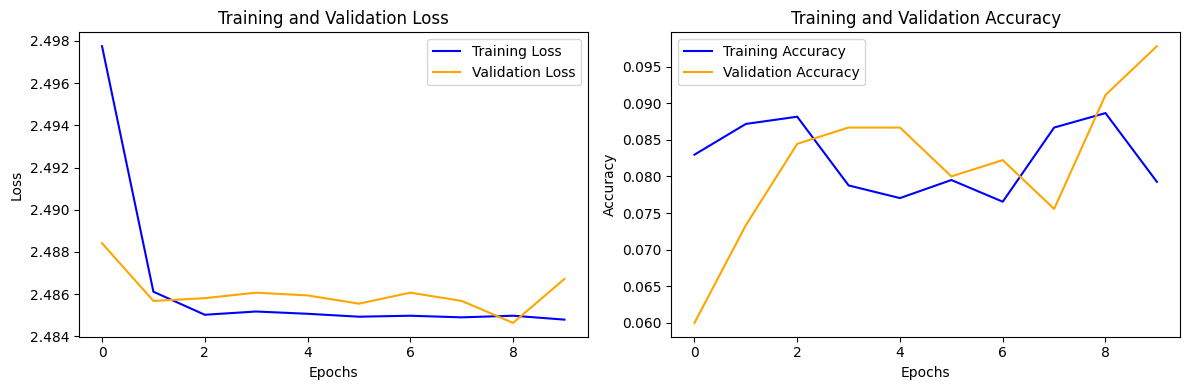

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss', color='blue')
plt.plot(val_loss_list, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Training Accuracy', color='blue')
plt.plot(val_acc_list, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Test contrastive pre training

In [ ]:
# Assuming you have the same architecture for your model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model state_dict
saved_model_path = '/content/drive/MyDrive/College/DL/Final Project/fine_tuned_clip_model.pth'
model.load_state_dict(torch.load(saved_model_path))

# Set the model to evaluation mode
model.eval()

correct = []
correct_per_class = {}

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[mod_class_names.index(label)] == cls:
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')


currently calculating:  Birman
Accuracy on class Birman is: 0.4533333333333333
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.0
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.17333333333333334
currently calculating:  Bombay
Accuracy on class Bombay is: 0.48
currently calculating:  Persian
Accuracy on class Persian is: 0.0
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.0
currently calculating:  Bengal
Accuracy on class Bengal is: 0.0
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.0
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.0
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.0
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.0
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.0
currently calculating:  Tuxedo
Accuracy on class Tuxedo is: 0.0
currently calculating:  Russian Blue
A

## Supervised training (encoder weights unfrozen after 5 epochs)

### without regularization, lr 10^-5

In [ ]:
import torch
import clip
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

# Assuming you have the same architecture for your model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# # Load the saved model state_dict
# saved_model_path = '/content/drive/MyDrive/College/DL/Final Project/fine_tuned_clip_model.pth'
# model.load_state_dict(torch.load(saved_model_path))

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Choose loss function and optimizer for classification
classification_loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Separate parameters for encoder and classification head
encoder_params = list(model.visual.parameters())
classifier_params = list(model.classification_head.parameters())

# Different learning rates for encoder and classifier
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': 0.00001},
    {'params': classifier_params, 'lr': 0.001}
])

# Define a learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Fine-tune the model with supervised learning
num_epochs = 20
freeze_encoder_epochs = 5  # Number of epochs to freeze the encoder

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    # Freeze encoder for the specified number of epochs
    if epoch < freeze_encoder_epochs:
        for param in model.visual.parameters():
            param.requires_grad = False
    else:
        for param in model.visual.parameters():
            param.requires_grad = True

    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:
        inputs, labels = batch
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Extract image features from the encoder
        image_features = model.encode_image(inputs)

        # Forward pass through the new classification head
        logits = model.classification_head(image_features.float())

        # Compute the classification loss
        ground_truth = torch.tensor([mod_class_names.index(label) for label in labels],
                                    dtype=torch.long, device=device)
        classification_loss_value = classification_loss(logits, ground_truth)

        # Backward pass and update the model's parameters
        classification_loss_value.backward()

        if param.requires_grad:
            if device == "cpu":
                optimizer.step()
            else:
                # Convert model's parameters to FP32 format, update, and convert back
                convert_models_to_fp32(model)
                optimizer.step()
        else:
            optimizer.step()

        # Update the total loss and accuracy for printing
        total_loss += classification_loss_value.item()
        _, predicted = logits.max(1)
        total_samples += len(labels)
        total_correct += (predicted == ground_truth).to(torch.float32).sum().item()

    # Calculate training accuracy and loss
    training_accuracy = total_correct / total_samples
    training_loss = total_loss / len(train_loader)
    train_acc_list.append(training_accuracy)
    train_loss_list.append(training_loss)

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, total=len(val_loader))
        for val_batch in val_pbar:
            val_inputs, val_labels = val_batch
            val_inputs = val_inputs.to(device)

            # Extract image features from the encoder
            val_image_features = model.encode_image(val_inputs)

            # Forward pass through the new classification head
            val_logits = model.classification_head(val_image_features.float())

            # Compute the classification loss
            val_ground_truth = torch.tensor([mod_class_names.index(label) for label in val_labels],
                                            dtype=torch.long, device=device)
            val_classification_loss_value = classification_loss(val_logits, val_ground_truth)

            val_total_loss += val_classification_loss_value.item()

            _, val_predicted = val_logits.max(1)
            val_total_samples += len(val_labels)
            val_total_correct += (val_predicted == val_ground_truth).to(torch.float32).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = val_total_correct / val_total_samples
    val_loss = val_total_loss / len(val_loader)
    val_acc_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    # scheduler.step()

    # Print training and validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the fine-tuned model
clip.model.convert_weights(model)
torch.save({
    'clip_state_dict': model.state_dict(),
    'classification_head_state_dict': model.classification_head.state_dict()
}, '/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model.pth')

  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Epoch 1/20, Training Loss: 2.2065, Training Accuracy: 31.36%, Validation Loss: 1.9910, Validation Accuracy: 40.22%


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


Epoch 2/20, Training Loss: 1.8084, Training Accuracy: 46.37%, Validation Loss: 1.7511, Validation Accuracy: 48.22%


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Epoch 3/20, Training Loss: 1.6118, Training Accuracy: 51.88%, Validation Loss: 1.6123, Validation Accuracy: 49.56%


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch 4/20, Training Loss: 1.4847, Training Accuracy: 55.68%, Validation Loss: 1.5350, Validation Accuracy: 49.78%


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Epoch 5/20, Training Loss: 1.4042, Training Accuracy: 57.16%, Validation Loss: 1.4876, Validation Accuracy: 51.33%


100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Epoch 6/20, Training Loss: 1.1010, Training Accuracy: 62.52%, Validation Loss: 1.0893, Validation Accuracy: 65.33%


100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 7/20, Training Loss: 0.7491, Training Accuracy: 73.26%, Validation Loss: 1.0371, Validation Accuracy: 66.22%


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Epoch 8/20, Training Loss: 0.6304, Training Accuracy: 77.41%, Validation Loss: 0.9822, Validation Accuracy: 70.22%


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 9/20, Training Loss: 0.4838, Training Accuracy: 83.14%, Validation Loss: 1.0112, Validation Accuracy: 70.44%


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


Epoch 10/20, Training Loss: 0.3775, Training Accuracy: 86.91%, Validation Loss: 0.9819, Validation Accuracy: 66.89%


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Epoch 11/20, Training Loss: 0.2726, Training Accuracy: 90.07%, Validation Loss: 1.1283, Validation Accuracy: 70.67%


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Epoch 12/20, Training Loss: 0.2193, Training Accuracy: 93.01%, Validation Loss: 1.1352, Validation Accuracy: 68.67%


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Epoch 13/20, Training Loss: 0.1879, Training Accuracy: 93.16%, Validation Loss: 1.2095, Validation Accuracy: 70.00%


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


Epoch 14/20, Training Loss: 0.1460, Training Accuracy: 95.28%, Validation Loss: 1.1900, Validation Accuracy: 70.22%


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


Epoch 15/20, Training Loss: 0.1163, Training Accuracy: 96.25%, Validation Loss: 1.2461, Validation Accuracy: 70.44%


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Epoch 16/20, Training Loss: 0.0903, Training Accuracy: 97.16%, Validation Loss: 1.2345, Validation Accuracy: 70.00%


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Epoch 17/20, Training Loss: 0.0600, Training Accuracy: 97.93%, Validation Loss: 1.3089, Validation Accuracy: 68.89%


100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


Epoch 18/20, Training Loss: 0.0719, Training Accuracy: 97.43%, Validation Loss: 1.3361, Validation Accuracy: 70.67%


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Epoch 19/20, Training Loss: 0.0856, Training Accuracy: 97.11%, Validation Loss: 1.5524, Validation Accuracy: 67.56%


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


Epoch 20/20, Training Loss: 0.0885, Training Accuracy: 97.01%, Validation Loss: 1.5257, Validation Accuracy: 69.56%


### With regularization (weight decay 1e-3), lr 10^-5

In [ ]:
import torch
import clip
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

# Assuming you have the same architecture for your model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# # Load the saved model state_dict
# saved_model_path = '/content/drive/MyDrive/College/DL/Final Project/fine_tuned_clip_model.pth'
# model.load_state_dict(torch.load(saved_model_path))

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Choose loss function and optimizer for classification
classification_loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Separate parameters for encoder and classification head
encoder_params = list(model.visual.parameters())
classifier_params = list(model.classification_head.parameters())

# Different learning rates for encoder and classifier
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr':0.00001,'weight_decay':1e-3},
    {'params': classifier_params, 'lr': 0.001}
])

# Define a learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Fine-tune the model with supervised learning
num_epochs = 20
freeze_encoder_epochs = 5  # Number of epochs to freeze the encoder

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    # Freeze encoder for the specified number of epochs
    if epoch < freeze_encoder_epochs:
        for param in model.visual.parameters():
            param.requires_grad = False
    else:
        for param in model.visual.parameters():
            param.requires_grad = True

    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:
        inputs, labels = batch
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Extract image features from the encoder
        image_features = model.encode_image(inputs)

        # Forward pass through the new classification head
        logits = model.classification_head(image_features.float())

        # Compute the classification loss
        ground_truth = torch.tensor([mod_class_names.index(label) for label in labels],
                                    dtype=torch.long, device=device)
        classification_loss_value = classification_loss(logits, ground_truth)

        # Backward pass and update the model's parameters
        classification_loss_value.backward()

        if param.requires_grad:
            if device == "cpu":
                optimizer.step()
            else:
                # Convert model's parameters to FP32 format, update, and convert back
                convert_models_to_fp32(model)
                optimizer.step()
        else:
            optimizer.step()

        # Update the total loss and accuracy for printing
        total_loss += classification_loss_value.item()
        _, predicted = logits.max(1)
        total_samples += len(labels)
        total_correct += (predicted == ground_truth).to(torch.float32).sum().item()

    # Calculate training accuracy and loss
    training_accuracy = total_correct / total_samples
    training_loss = total_loss / len(train_loader)
    train_acc_list.append(training_accuracy)
    train_loss_list.append(training_loss)

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, total=len(val_loader))
        for val_batch in val_pbar:
            val_inputs, val_labels = val_batch
            val_inputs = val_inputs.to(device)

            # Extract image features from the encoder
            val_image_features = model.encode_image(val_inputs)

            # Forward pass through the new classification head
            val_logits = model.classification_head(val_image_features.float())

            # Compute the classification loss
            val_ground_truth = torch.tensor([mod_class_names.index(label) for label in val_labels],
                                            dtype=torch.long, device=device)
            val_classification_loss_value = classification_loss(val_logits, val_ground_truth)

            val_total_loss += val_classification_loss_value.item()

            _, val_predicted = val_logits.max(1)
            val_total_samples += len(val_labels)
            val_total_correct += (val_predicted == val_ground_truth).to(torch.float32).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = val_total_correct / val_total_samples
    val_loss = val_total_loss / len(val_loader)
    val_acc_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    # scheduler.step()

    # Print training and validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the fine-tuned model
clip.model.convert_weights(model)
torch.save({
    'clip_state_dict': model.state_dict(),
    'classification_head_state_dict': model.classification_head.state_dict()
}, '/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted.pth')

100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


Epoch 1/20, Training Loss: 2.2056, Training Accuracy: 31.56%, Validation Loss: 1.9681, Validation Accuracy: 44.89%


100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


Epoch 2/20, Training Loss: 1.7986, Training Accuracy: 47.58%, Validation Loss: 1.7557, Validation Accuracy: 47.33%


100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


Epoch 3/20, Training Loss: 1.6091, Training Accuracy: 52.25%, Validation Loss: 1.6304, Validation Accuracy: 50.00%


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Epoch 4/20, Training Loss: 1.4955, Training Accuracy: 53.75%, Validation Loss: 1.5269, Validation Accuracy: 52.22%


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch 5/20, Training Loss: 1.4041, Training Accuracy: 57.38%, Validation Loss: 1.4651, Validation Accuracy: 52.22%


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch 6/20, Training Loss: 1.0923, Training Accuracy: 61.28%, Validation Loss: 1.1555, Validation Accuracy: 64.44%


100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Epoch 7/20, Training Loss: 0.7744, Training Accuracy: 72.42%, Validation Loss: 1.0715, Validation Accuracy: 66.89%


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Epoch 8/20, Training Loss: 0.6314, Training Accuracy: 78.05%, Validation Loss: 0.9415, Validation Accuracy: 71.56%


100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 9/20, Training Loss: 0.4556, Training Accuracy: 84.35%, Validation Loss: 1.0871, Validation Accuracy: 68.22%


100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


Epoch 10/20, Training Loss: 0.3871, Training Accuracy: 86.52%, Validation Loss: 1.0247, Validation Accuracy: 71.11%


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Epoch 11/20, Training Loss: 0.2761, Training Accuracy: 90.81%, Validation Loss: 0.9983, Validation Accuracy: 71.78%


100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 12/20, Training Loss: 0.1826, Training Accuracy: 93.88%, Validation Loss: 1.0813, Validation Accuracy: 70.89%


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Epoch 13/20, Training Loss: 0.1606, Training Accuracy: 94.49%, Validation Loss: 1.0407, Validation Accuracy: 70.44%


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Epoch 14/20, Training Loss: 0.1125, Training Accuracy: 96.57%, Validation Loss: 1.2148, Validation Accuracy: 71.11%


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Epoch 15/20, Training Loss: 0.0897, Training Accuracy: 97.41%, Validation Loss: 1.1318, Validation Accuracy: 70.22%


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Epoch 16/20, Training Loss: 0.0921, Training Accuracy: 96.96%, Validation Loss: 1.4031, Validation Accuracy: 70.67%


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Epoch 17/20, Training Loss: 0.0681, Training Accuracy: 97.70%, Validation Loss: 1.3929, Validation Accuracy: 69.78%


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Epoch 18/20, Training Loss: 0.0936, Training Accuracy: 96.72%, Validation Loss: 1.3719, Validation Accuracy: 66.44%


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch 19/20, Training Loss: 0.0932, Training Accuracy: 96.67%, Validation Loss: 1.3040, Validation Accuracy: 70.22%


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Epoch 20/20, Training Loss: 0.0932, Training Accuracy: 96.77%, Validation Loss: 1.6764, Validation Accuracy: 69.78%


### With regularization (weight decay 1e-2), lr 10^-5

In [ ]:
import torch
import clip
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

# Assuming you have the same architecture for your model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# # Load the saved model state_dict
# saved_model_path = '/content/drive/MyDrive/College/DL/Final Project/fine_tuned_clip_model.pth'
# model.load_state_dict(torch.load(saved_model_path))

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Choose loss function and optimizer for classification
classification_loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Separate parameters for encoder and classification head
encoder_params = list(model.visual.parameters())
classifier_params = list(model.classification_head.parameters())

# Different learning rates for encoder and classifier
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr':0.00001,'weight_decay':1e-2},
    {'params': classifier_params, 'lr': 0.001}
])

# Define a learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Fine-tune the model with supervised learning
num_epochs = 20
freeze_encoder_epochs = 5  # Number of epochs to freeze the encoder

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    # Freeze encoder for the specified number of epochs
    if epoch < freeze_encoder_epochs:
        for param in model.visual.parameters():
            param.requires_grad = False
    else:
        for param in model.visual.parameters():
            param.requires_grad = True

    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:
        inputs, labels = batch
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Extract image features from the encoder
        image_features = model.encode_image(inputs)

        # Forward pass through the new classification head
        logits = model.classification_head(image_features.float())

        # Compute the classification loss
        ground_truth = torch.tensor([mod_class_names.index(label) for label in labels],
                                    dtype=torch.long, device=device)
        classification_loss_value = classification_loss(logits, ground_truth)

        # Backward pass and update the model's parameters
        classification_loss_value.backward()

        if param.requires_grad:
            if device == "cpu":
                optimizer.step()
            else:
                # Convert model's parameters to FP32 format, update, and convert back
                convert_models_to_fp32(model)
                optimizer.step()
        else:
            optimizer.step()

        # Update the total loss and accuracy for printing
        total_loss += classification_loss_value.item()
        _, predicted = logits.max(1)
        total_samples += len(labels)
        total_correct += (predicted == ground_truth).to(torch.float32).sum().item()

    # Calculate training accuracy and loss
    training_accuracy = total_correct / total_samples
    training_loss = total_loss / len(train_loader)
    train_acc_list.append(training_accuracy)
    train_loss_list.append(training_loss)

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, total=len(val_loader))
        for val_batch in val_pbar:
            val_inputs, val_labels = val_batch
            val_inputs = val_inputs.to(device)

            # Extract image features from the encoder
            val_image_features = model.encode_image(val_inputs)

            # Forward pass through the new classification head
            val_logits = model.classification_head(val_image_features.float())

            # Compute the classification loss
            val_ground_truth = torch.tensor([mod_class_names.index(label) for label in val_labels],
                                            dtype=torch.long, device=device)
            val_classification_loss_value = classification_loss(val_logits, val_ground_truth)

            val_total_loss += val_classification_loss_value.item()

            _, val_predicted = val_logits.max(1)
            val_total_samples += len(val_labels)
            val_total_correct += (val_predicted == val_ground_truth).to(torch.float32).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = val_total_correct / val_total_samples
    val_loss = val_total_loss / len(val_loader)
    val_acc_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    # scheduler.step()

    # Print training and validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the fine-tuned model
clip.model.convert_weights(model)
torch.save({
    'clip_state_dict': model.state_dict(),
    'classification_head_state_dict': model.classification_head.state_dict()
}, '/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted2.pth')

100%|██████████| 15/15 [02:48<00:00, 11.23s/it]


Epoch 1/20, Training Loss: 2.1891, Training Accuracy: 30.64%, Validation Loss: 2.0017, Validation Accuracy: 38.44%


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


Epoch 2/20, Training Loss: 1.7914, Training Accuracy: 47.43%, Validation Loss: 1.7482, Validation Accuracy: 46.89%


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch 3/20, Training Loss: 1.6022, Training Accuracy: 52.47%, Validation Loss: 1.6297, Validation Accuracy: 50.22%


100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


Epoch 4/20, Training Loss: 1.4798, Training Accuracy: 55.58%, Validation Loss: 1.5262, Validation Accuracy: 51.78%


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Epoch 5/20, Training Loss: 1.4045, Training Accuracy: 57.33%, Validation Loss: 1.4570, Validation Accuracy: 52.89%


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch 6/20, Training Loss: 1.0791, Training Accuracy: 62.54%, Validation Loss: 1.0293, Validation Accuracy: 65.56%


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Epoch 7/20, Training Loss: 0.7832, Training Accuracy: 72.54%, Validation Loss: 1.0426, Validation Accuracy: 65.33%


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 8/20, Training Loss: 0.6177, Training Accuracy: 77.75%, Validation Loss: 1.0875, Validation Accuracy: 65.78%


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


Epoch 9/20, Training Loss: 0.4954, Training Accuracy: 82.27%, Validation Loss: 1.0350, Validation Accuracy: 68.89%


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Epoch 10/20, Training Loss: 0.3632, Training Accuracy: 87.31%, Validation Loss: 1.0291, Validation Accuracy: 68.22%


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Epoch 11/20, Training Loss: 0.2964, Training Accuracy: 90.25%, Validation Loss: 1.1934, Validation Accuracy: 70.00%


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


Epoch 12/20, Training Loss: 0.2504, Training Accuracy: 91.38%, Validation Loss: 1.2814, Validation Accuracy: 68.44%


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


Epoch 13/20, Training Loss: 0.1928, Training Accuracy: 93.56%, Validation Loss: 1.1816, Validation Accuracy: 66.67%


100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


Epoch 14/20, Training Loss: 0.1416, Training Accuracy: 95.33%, Validation Loss: 1.1992, Validation Accuracy: 67.56%


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Epoch 15/20, Training Loss: 0.1324, Training Accuracy: 95.41%, Validation Loss: 1.4091, Validation Accuracy: 68.44%


100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


Epoch 16/20, Training Loss: 0.1402, Training Accuracy: 95.38%, Validation Loss: 1.4653, Validation Accuracy: 68.67%


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Epoch 17/20, Training Loss: 0.1053, Training Accuracy: 96.35%, Validation Loss: 1.4362, Validation Accuracy: 63.78%


100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


Epoch 18/20, Training Loss: 0.0979, Training Accuracy: 96.54%, Validation Loss: 1.2637, Validation Accuracy: 69.56%


100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


Epoch 19/20, Training Loss: 0.1284, Training Accuracy: 95.60%, Validation Loss: 1.4414, Validation Accuracy: 65.33%


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


Epoch 20/20, Training Loss: 0.0978, Training Accuracy: 97.01%, Validation Loss: 1.6179, Validation Accuracy: 68.22%


### without regularization, lr 10^-6

In [ ]:
import torch
import clip
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

# Assuming you have the same architecture for your model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# # Load the saved model state_dict
# saved_model_path = '/content/drive/MyDrive/College/DL/Final Project/fine_tuned_clip_model.pth'
# model.load_state_dict(torch.load(saved_model_path))

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Choose loss function and optimizer for classification
classification_loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Separate parameters for encoder and classification head
encoder_params = list(model.visual.parameters())
classifier_params = list(model.classification_head.parameters())

# Different learning rates for encoder and classifier
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr':0.000001},
    {'params': classifier_params, 'lr': 0.001}
])

# Define a learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Fine-tune the model with supervised learning
num_epochs = 20
freeze_encoder_epochs = 5  # Number of epochs to freeze the encoder

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    # Freeze encoder for the specified number of epochs
    if epoch < freeze_encoder_epochs:
        for param in model.visual.parameters():
            param.requires_grad = False
    else:
        for param in model.visual.parameters():
            param.requires_grad = True

    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:
        inputs, labels = batch
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Extract image features from the encoder
        image_features = model.encode_image(inputs)

        # Forward pass through the new classification head
        logits = model.classification_head(image_features.float())

        # Compute the classification loss
        ground_truth = torch.tensor([mod_class_names.index(label) for label in labels],
                                    dtype=torch.long, device=device)
        classification_loss_value = classification_loss(logits, ground_truth)

        # Backward pass and update the model's parameters
        classification_loss_value.backward()

        if param.requires_grad:
            if device == "cpu":
                optimizer.step()
            else:
                # Convert model's parameters to FP32 format, update, and convert back
                convert_models_to_fp32(model)
                optimizer.step()
        else:
            optimizer.step()

        # Update the total loss and accuracy for printing
        total_loss += classification_loss_value.item()
        _, predicted = logits.max(1)
        total_samples += len(labels)
        total_correct += (predicted == ground_truth).to(torch.float32).sum().item()

    # Calculate training accuracy and loss
    training_accuracy = total_correct / total_samples
    training_loss = total_loss / len(train_loader)
    train_acc_list.append(training_accuracy)
    train_loss_list.append(training_loss)

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, total=len(val_loader))
        for val_batch in val_pbar:
            val_inputs, val_labels = val_batch
            val_inputs = val_inputs.to(device)

            # Extract image features from the encoder
            val_image_features = model.encode_image(val_inputs)

            # Forward pass through the new classification head
            val_logits = model.classification_head(val_image_features.float())

            # Compute the classification loss
            val_ground_truth = torch.tensor([mod_class_names.index(label) for label in val_labels],
                                            dtype=torch.long, device=device)
            val_classification_loss_value = classification_loss(val_logits, val_ground_truth)

            val_total_loss += val_classification_loss_value.item()

            _, val_predicted = val_logits.max(1)
            val_total_samples += len(val_labels)
            val_total_correct += (val_predicted == val_ground_truth).to(torch.float32).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = val_total_correct / val_total_samples
    val_loss = val_total_loss / len(val_loader)
    val_acc_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    # scheduler.step()

    # Print training and validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the fine-tuned model
clip.model.convert_weights(model)
torch.save({
    'clip_state_dict': model.state_dict(),
    'classification_head_state_dict': model.classification_head.state_dict()
}, '/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted5.pth')

100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


Epoch 1/20, Training Loss: 2.1980, Training Accuracy: 30.96%, Validation Loss: 1.9962, Validation Accuracy: 39.56%


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Epoch 2/20, Training Loss: 1.8019, Training Accuracy: 46.05%, Validation Loss: 1.7552, Validation Accuracy: 47.56%


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Epoch 3/20, Training Loss: 1.6020, Training Accuracy: 52.42%, Validation Loss: 1.6084, Validation Accuracy: 51.56%


100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


Epoch 4/20, Training Loss: 1.4870, Training Accuracy: 54.25%, Validation Loss: 1.5308, Validation Accuracy: 52.44%


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 5/20, Training Loss: 1.4008, Training Accuracy: 58.15%, Validation Loss: 1.4570, Validation Accuracy: 53.56%


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Epoch 6/20, Training Loss: 1.1366, Training Accuracy: 61.68%, Validation Loss: 1.1472, Validation Accuracy: 60.89%


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


Epoch 7/20, Training Loss: 0.9190, Training Accuracy: 68.02%, Validation Loss: 1.0556, Validation Accuracy: 65.11%


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


Epoch 8/20, Training Loss: 0.8157, Training Accuracy: 70.94%, Validation Loss: 0.9887, Validation Accuracy: 66.67%


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


Epoch 9/20, Training Loss: 0.7413, Training Accuracy: 73.63%, Validation Loss: 0.9758, Validation Accuracy: 68.89%


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


Epoch 10/20, Training Loss: 0.6557, Training Accuracy: 76.99%, Validation Loss: 0.9059, Validation Accuracy: 70.00%


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Epoch 11/20, Training Loss: 0.6068, Training Accuracy: 78.54%, Validation Loss: 0.9384, Validation Accuracy: 70.00%


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


Epoch 12/20, Training Loss: 0.5501, Training Accuracy: 80.99%, Validation Loss: 0.9081, Validation Accuracy: 70.67%


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Epoch 13/20, Training Loss: 0.4933, Training Accuracy: 82.67%, Validation Loss: 0.9606, Validation Accuracy: 71.11%


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


Epoch 14/20, Training Loss: 0.4631, Training Accuracy: 84.27%, Validation Loss: 0.9120, Validation Accuracy: 69.78%


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Epoch 15/20, Training Loss: 0.4143, Training Accuracy: 85.60%, Validation Loss: 0.9235, Validation Accuracy: 70.67%


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


Epoch 16/20, Training Loss: 0.3647, Training Accuracy: 87.80%, Validation Loss: 0.9438, Validation Accuracy: 72.00%


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Epoch 17/20, Training Loss: 0.3279, Training Accuracy: 89.26%, Validation Loss: 0.9327, Validation Accuracy: 72.67%


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Epoch 18/20, Training Loss: 0.2942, Training Accuracy: 90.59%, Validation Loss: 0.9520, Validation Accuracy: 71.33%


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


Epoch 19/20, Training Loss: 0.2608, Training Accuracy: 91.51%, Validation Loss: 0.9748, Validation Accuracy: 71.78%


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Epoch 20/20, Training Loss: 0.2297, Training Accuracy: 92.84%, Validation Loss: 0.9693, Validation Accuracy: 71.78%


### with regularization (weight decay 1e-2), lr 10^-6

In [ ]:
import torch
import clip
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

# Assuming you have the same architecture for your model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# # Load the saved model state_dict
# saved_model_path = '/content/drive/MyDrive/College/DL/Final Project/fine_tuned_clip_model.pth'
# model.load_state_dict(torch.load(saved_model_path))

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Choose loss function and optimizer for classification
classification_loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Separate parameters for encoder and classification head
encoder_params = list(model.visual.parameters())
classifier_params = list(model.classification_head.parameters())

# Different learning rates for encoder and classifier
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr':0.000001,'weight_decay':1e-2},
    {'params': classifier_params, 'lr': 0.001}
])

# Define a learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Fine-tune the model with supervised learning
num_epochs = 20
freeze_encoder_epochs = 5  # Number of epochs to freeze the encoder

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    # Freeze encoder for the specified number of epochs
    if epoch < freeze_encoder_epochs:
        for param in model.visual.parameters():
            param.requires_grad = False
    else:
        for param in model.visual.parameters():
            param.requires_grad = True

    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:
        inputs, labels = batch
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Extract image features from the encoder
        image_features = model.encode_image(inputs)

        # Forward pass through the new classification head
        logits = model.classification_head(image_features.float())

        # Compute the classification loss
        ground_truth = torch.tensor([mod_class_names.index(label) for label in labels],
                                    dtype=torch.long, device=device)
        classification_loss_value = classification_loss(logits, ground_truth)

        # Backward pass and update the model's parameters
        classification_loss_value.backward()

        if param.requires_grad:
            if device == "cpu":
                optimizer.step()
            else:
                # Convert model's parameters to FP32 format, update, and convert back
                convert_models_to_fp32(model)
                optimizer.step()
        else:
            optimizer.step()

        # Update the total loss and accuracy for printing
        total_loss += classification_loss_value.item()
        _, predicted = logits.max(1)
        total_samples += len(labels)
        total_correct += (predicted == ground_truth).to(torch.float32).sum().item()

    # Calculate training accuracy and loss
    training_accuracy = total_correct / total_samples
    training_loss = total_loss / len(train_loader)
    train_acc_list.append(training_accuracy)
    train_loss_list.append(training_loss)

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, total=len(val_loader))
        for val_batch in val_pbar:
            val_inputs, val_labels = val_batch
            val_inputs = val_inputs.to(device)

            # Extract image features from the encoder
            val_image_features = model.encode_image(val_inputs)

            # Forward pass through the new classification head
            val_logits = model.classification_head(val_image_features.float())

            # Compute the classification loss
            val_ground_truth = torch.tensor([mod_class_names.index(label) for label in val_labels],
                                            dtype=torch.long, device=device)
            val_classification_loss_value = classification_loss(val_logits, val_ground_truth)

            val_total_loss += val_classification_loss_value.item()

            _, val_predicted = val_logits.max(1)
            val_total_samples += len(val_labels)
            val_total_correct += (val_predicted == val_ground_truth).to(torch.float32).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = val_total_correct / val_total_samples
    val_loss = val_total_loss / len(val_loader)
    val_acc_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    # scheduler.step()

    # Print training and validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the fine-tuned model
clip.model.convert_weights(model)
torch.save({
    'clip_state_dict': model.state_dict(),
    'classification_head_state_dict': model.classification_head.state_dict()
}, '/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted3.pth')

100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


Epoch 1/20, Training Loss: 2.2195, Training Accuracy: 30.25%, Validation Loss: 2.0067, Validation Accuracy: 41.78%


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Epoch 2/20, Training Loss: 1.8039, Training Accuracy: 46.69%, Validation Loss: 1.7789, Validation Accuracy: 44.00%


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 3/20, Training Loss: 1.6037, Training Accuracy: 52.47%, Validation Loss: 1.6261, Validation Accuracy: 51.11%


100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


Epoch 4/20, Training Loss: 1.4799, Training Accuracy: 55.65%, Validation Loss: 1.5569, Validation Accuracy: 52.44%


100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Epoch 5/20, Training Loss: 1.4118, Training Accuracy: 56.40%, Validation Loss: 1.4813, Validation Accuracy: 52.00%


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Epoch 6/20, Training Loss: 1.1130, Training Accuracy: 61.73%, Validation Loss: 1.1349, Validation Accuracy: 63.78%


100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


Epoch 7/20, Training Loss: 0.9024, Training Accuracy: 68.62%, Validation Loss: 1.0509, Validation Accuracy: 65.33%


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Epoch 8/20, Training Loss: 0.8205, Training Accuracy: 71.14%, Validation Loss: 0.9868, Validation Accuracy: 66.89%


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Epoch 9/20, Training Loss: 0.7240, Training Accuracy: 74.67%, Validation Loss: 0.9445, Validation Accuracy: 70.67%


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


Epoch 10/20, Training Loss: 0.6685, Training Accuracy: 76.42%, Validation Loss: 0.9758, Validation Accuracy: 69.78%


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Epoch 11/20, Training Loss: 0.5987, Training Accuracy: 79.41%, Validation Loss: 0.9292, Validation Accuracy: 68.44%


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Epoch 12/20, Training Loss: 0.5517, Training Accuracy: 81.21%, Validation Loss: 0.9340, Validation Accuracy: 69.78%


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 13/20, Training Loss: 0.5067, Training Accuracy: 82.20%, Validation Loss: 0.9339, Validation Accuracy: 70.44%


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Epoch 14/20, Training Loss: 0.4522, Training Accuracy: 84.00%, Validation Loss: 0.9270, Validation Accuracy: 70.22%


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Epoch 15/20, Training Loss: 0.4143, Training Accuracy: 86.15%, Validation Loss: 0.9529, Validation Accuracy: 71.56%


100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 16/20, Training Loss: 0.3706, Training Accuracy: 87.65%, Validation Loss: 0.9418, Validation Accuracy: 71.56%


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


Epoch 17/20, Training Loss: 0.3365, Training Accuracy: 89.11%, Validation Loss: 0.9615, Validation Accuracy: 71.11%


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Epoch 18/20, Training Loss: 0.2946, Training Accuracy: 90.74%, Validation Loss: 0.9766, Validation Accuracy: 72.00%


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


Epoch 19/20, Training Loss: 0.2799, Training Accuracy: 91.19%, Validation Loss: 0.9705, Validation Accuracy: 71.33%


100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


Epoch 20/20, Training Loss: 0.2341, Training Accuracy: 92.86%, Validation Loss: 0.9989, Validation Accuracy: 71.56%


### with regularization (weight decay 1e-1), lr 10^-6

In [ ]:
import torch
import clip
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

# Assuming you have the same architecture for your model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# # Load the saved model state_dict
# saved_model_path = '/content/drive/MyDrive/College/DL/Final Project/fine_tuned_clip_model.pth'
# model.load_state_dict(torch.load(saved_model_path))

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Choose loss function and optimizer for classification
classification_loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Separate parameters for encoder and classification head
encoder_params = list(model.visual.parameters())
classifier_params = list(model.classification_head.parameters())

# Different learning rates for encoder and classifier
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr':0.000001,'weight_decay':1e-2},
    {'params': classifier_params, 'lr': 0.001}
])

# Define a learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Fine-tune the model with supervised learning
num_epochs = 20
freeze_encoder_epochs = 5  # Number of epochs to freeze the encoder

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    # Freeze encoder for the specified number of epochs
    if epoch < freeze_encoder_epochs:
        for param in model.visual.parameters():
            param.requires_grad = False
    else:
        for param in model.visual.parameters():
            param.requires_grad = True

    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:
        inputs, labels = batch
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Extract image features from the encoder
        image_features = model.encode_image(inputs)

        # Forward pass through the new classification head
        logits = model.classification_head(image_features.float())

        # Compute the classification loss
        ground_truth = torch.tensor([mod_class_names.index(label) for label in labels],
                                    dtype=torch.long, device=device)
        classification_loss_value = classification_loss(logits, ground_truth)

        # Backward pass and update the model's parameters
        classification_loss_value.backward()

        if param.requires_grad:
            if device == "cpu":
                optimizer.step()
            else:
                # Convert model's parameters to FP32 format, update, and convert back
                convert_models_to_fp32(model)
                optimizer.step()
        else:
            optimizer.step()

        # Update the total loss and accuracy for printing
        total_loss += classification_loss_value.item()
        _, predicted = logits.max(1)
        total_samples += len(labels)
        total_correct += (predicted == ground_truth).to(torch.float32).sum().item()

    # Calculate training accuracy and loss
    training_accuracy = total_correct / total_samples
    training_loss = total_loss / len(train_loader)
    train_acc_list.append(training_accuracy)
    train_loss_list.append(training_loss)

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, total=len(val_loader))
        for val_batch in val_pbar:
            val_inputs, val_labels = val_batch
            val_inputs = val_inputs.to(device)

            # Extract image features from the encoder
            val_image_features = model.encode_image(val_inputs)

            # Forward pass through the new classification head
            val_logits = model.classification_head(val_image_features.float())

            # Compute the classification loss
            val_ground_truth = torch.tensor([mod_class_names.index(label) for label in val_labels],
                                            dtype=torch.long, device=device)
            val_classification_loss_value = classification_loss(val_logits, val_ground_truth)

            val_total_loss += val_classification_loss_value.item()

            _, val_predicted = val_logits.max(1)
            val_total_samples += len(val_labels)
            val_total_correct += (val_predicted == val_ground_truth).to(torch.float32).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = val_total_correct / val_total_samples
    val_loss = val_total_loss / len(val_loader)
    val_acc_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    # scheduler.step()

    # Print training and validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the fine-tuned model
clip.model.convert_weights(model)
torch.save({
    'clip_state_dict': model.state_dict(),
    'classification_head_state_dict': model.classification_head.state_dict()
}, '/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted4.pth')

  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 15/15 [01:41<00:00,  6.78s/it]


Epoch 1/20, Training Loss: 2.2112, Training Accuracy: 32.00%, Validation Loss: 1.9855, Validation Accuracy: 41.78%


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


Epoch 2/20, Training Loss: 1.8016, Training Accuracy: 46.42%, Validation Loss: 1.7494, Validation Accuracy: 47.11%


100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Epoch 3/20, Training Loss: 1.6054, Training Accuracy: 53.31%, Validation Loss: 1.6365, Validation Accuracy: 50.00%


100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


Epoch 4/20, Training Loss: 1.4974, Training Accuracy: 54.32%, Validation Loss: 1.5565, Validation Accuracy: 50.22%


100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Epoch 5/20, Training Loss: 1.4045, Training Accuracy: 56.20%, Validation Loss: 1.4546, Validation Accuracy: 53.11%


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Epoch 6/20, Training Loss: 1.1152, Training Accuracy: 62.86%, Validation Loss: 1.1113, Validation Accuracy: 60.00%


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


Epoch 7/20, Training Loss: 0.9072, Training Accuracy: 68.62%, Validation Loss: 1.0459, Validation Accuracy: 65.56%


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Epoch 8/20, Training Loss: 0.8122, Training Accuracy: 70.62%, Validation Loss: 0.9810, Validation Accuracy: 65.56%


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


Epoch 9/20, Training Loss: 0.7231, Training Accuracy: 74.99%, Validation Loss: 0.9921, Validation Accuracy: 68.00%


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Epoch 10/20, Training Loss: 0.6632, Training Accuracy: 76.22%, Validation Loss: 0.9242, Validation Accuracy: 68.44%


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Epoch 11/20, Training Loss: 0.6094, Training Accuracy: 78.32%, Validation Loss: 0.9118, Validation Accuracy: 68.67%


100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


Epoch 12/20, Training Loss: 0.5528, Training Accuracy: 81.04%, Validation Loss: 0.9084, Validation Accuracy: 71.33%


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Epoch 13/20, Training Loss: 0.4992, Training Accuracy: 82.64%, Validation Loss: 0.8983, Validation Accuracy: 69.33%


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


Epoch 14/20, Training Loss: 0.4405, Training Accuracy: 84.99%, Validation Loss: 0.9038, Validation Accuracy: 71.33%


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


Epoch 15/20, Training Loss: 0.4164, Training Accuracy: 86.17%, Validation Loss: 0.9087, Validation Accuracy: 69.11%


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 16/20, Training Loss: 0.3749, Training Accuracy: 87.21%, Validation Loss: 0.9704, Validation Accuracy: 71.56%


100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Epoch 17/20, Training Loss: 0.3314, Training Accuracy: 88.81%, Validation Loss: 0.9237, Validation Accuracy: 70.44%


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Epoch 18/20, Training Loss: 0.2898, Training Accuracy: 90.32%, Validation Loss: 0.9719, Validation Accuracy: 72.22%


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Epoch 19/20, Training Loss: 0.2690, Training Accuracy: 91.58%, Validation Loss: 1.0249, Validation Accuracy: 71.56%


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Epoch 20/20, Training Loss: 0.2431, Training Accuracy: 92.49%, Validation Loss: 0.9745, Validation Accuracy: 71.78%


### without regularization, lr 10^-7

In [ ]:
import torch
import clip
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

# Assuming you have the same architecture for your model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# # Load the saved model state_dict
# saved_model_path = '/content/drive/MyDrive/College/DL/Final Project/fine_tuned_clip_model.pth'
# model.load_state_dict(torch.load(saved_model_path))

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Choose loss function and optimizer for classification
classification_loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Separate parameters for encoder and classification head
encoder_params = list(model.visual.parameters())
classifier_params = list(model.classification_head.parameters())

# Different learning rates for encoder and classifier
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr':0.0000001},
    {'params': classifier_params, 'lr': 0.001}
])

# Define a learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Fine-tune the model with supervised learning
num_epochs = 20
freeze_encoder_epochs = 5  # Number of epochs to freeze the encoder

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    # Freeze encoder for the specified number of epochs
    if epoch < freeze_encoder_epochs:
        for param in model.visual.parameters():
            param.requires_grad = False
    else:
        for param in model.visual.parameters():
            param.requires_grad = True

    total_loss = 0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:
        inputs, labels = batch
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Extract image features from the encoder
        image_features = model.encode_image(inputs)

        # Forward pass through the new classification head
        logits = model.classification_head(image_features.float())

        # Compute the classification loss
        ground_truth = torch.tensor([mod_class_names.index(label) for label in labels],
                                    dtype=torch.long, device=device)
        classification_loss_value = classification_loss(logits, ground_truth)

        # Backward pass and update the model's parameters
        classification_loss_value.backward()

        if param.requires_grad:
            if device == "cpu":
                optimizer.step()
            else:
                # Convert model's parameters to FP32 format, update, and convert back
                convert_models_to_fp32(model)
                optimizer.step()
        else:
            optimizer.step()

        # Update the total loss and accuracy for printing
        total_loss += classification_loss_value.item()
        _, predicted = logits.max(1)
        total_samples += len(labels)
        total_correct += (predicted == ground_truth).to(torch.float32).sum().item()

    # Calculate training accuracy and loss
    training_accuracy = total_correct / total_samples
    training_loss = total_loss / len(train_loader)
    train_acc_list.append(training_accuracy)
    train_loss_list.append(training_loss)

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, total=len(val_loader))
        for val_batch in val_pbar:
            val_inputs, val_labels = val_batch
            val_inputs = val_inputs.to(device)

            # Extract image features from the encoder
            val_image_features = model.encode_image(val_inputs)

            # Forward pass through the new classification head
            val_logits = model.classification_head(val_image_features.float())

            # Compute the classification loss
            val_ground_truth = torch.tensor([mod_class_names.index(label) for label in val_labels],
                                            dtype=torch.long, device=device)
            val_classification_loss_value = classification_loss(val_logits, val_ground_truth)

            val_total_loss += val_classification_loss_value.item()

            _, val_predicted = val_logits.max(1)
            val_total_samples += len(val_labels)
            val_total_correct += (val_predicted == val_ground_truth).to(torch.float32).sum().item()

    # Calculate validation accuracy and loss
    val_accuracy = val_total_correct / val_total_samples
    val_loss = val_total_loss / len(val_loader)
    val_acc_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    # scheduler.step()

    # Print training and validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the fine-tuned model
clip.model.convert_weights(model)
torch.save({
    'clip_state_dict': model.state_dict(),
    'classification_head_state_dict': model.classification_head.state_dict()
}, '/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted6.pth')

100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Epoch 1/20, Training Loss: 2.2038, Training Accuracy: 30.94%, Validation Loss: 1.9875, Validation Accuracy: 40.44%


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Epoch 2/20, Training Loss: 1.8068, Training Accuracy: 46.67%, Validation Loss: 1.7684, Validation Accuracy: 45.11%


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Epoch 3/20, Training Loss: 1.6056, Training Accuracy: 52.64%, Validation Loss: 1.6241, Validation Accuracy: 49.56%


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


Epoch 4/20, Training Loss: 1.4831, Training Accuracy: 55.21%, Validation Loss: 1.5440, Validation Accuracy: 51.11%


100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Epoch 5/20, Training Loss: 1.4128, Training Accuracy: 56.84%, Validation Loss: 1.4659, Validation Accuracy: 53.11%


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


Epoch 6/20, Training Loss: 1.2824, Training Accuracy: 59.26%, Validation Loss: 1.3224, Validation Accuracy: 55.78%


100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 7/20, Training Loss: 1.1518, Training Accuracy: 62.20%, Validation Loss: 1.2442, Validation Accuracy: 59.11%


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


Epoch 8/20, Training Loss: 1.0758, Training Accuracy: 63.06%, Validation Loss: 1.1978, Validation Accuracy: 59.11%


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


Epoch 9/20, Training Loss: 1.0205, Training Accuracy: 64.15%, Validation Loss: 1.1864, Validation Accuracy: 59.78%


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


Epoch 10/20, Training Loss: 0.9801, Training Accuracy: 65.43%, Validation Loss: 1.1270, Validation Accuracy: 60.67%


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Epoch 11/20, Training Loss: 0.9414, Training Accuracy: 67.41%, Validation Loss: 1.1086, Validation Accuracy: 60.89%


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


Epoch 12/20, Training Loss: 0.9057, Training Accuracy: 68.59%, Validation Loss: 1.0766, Validation Accuracy: 63.11%


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


Epoch 13/20, Training Loss: 0.8825, Training Accuracy: 70.02%, Validation Loss: 1.0778, Validation Accuracy: 63.78%


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


Epoch 14/20, Training Loss: 0.8528, Training Accuracy: 69.60%, Validation Loss: 1.0459, Validation Accuracy: 64.89%


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Epoch 15/20, Training Loss: 0.8269, Training Accuracy: 71.11%, Validation Loss: 1.0346, Validation Accuracy: 64.89%


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


Epoch 16/20, Training Loss: 0.8086, Training Accuracy: 71.19%, Validation Loss: 1.0345, Validation Accuracy: 65.56%


100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Epoch 17/20, Training Loss: 0.7988, Training Accuracy: 71.28%, Validation Loss: 1.0345, Validation Accuracy: 66.22%


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Epoch 18/20, Training Loss: 0.7623, Training Accuracy: 73.16%, Validation Loss: 1.0421, Validation Accuracy: 64.89%


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


Epoch 19/20, Training Loss: 0.7676, Training Accuracy: 73.46%, Validation Loss: 1.0059, Validation Accuracy: 66.44%


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


Epoch 20/20, Training Loss: 0.7492, Training Accuracy: 73.09%, Validation Loss: 1.0082, Validation Accuracy: 66.67%


# Testing

## without regularization, lr 10^-5

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the CLIP model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# Load the state dictionary
state_dict = torch.load('/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model.pth')

# Load the state dictionary of the CLIP model (excluding the custom classification head)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in state_dict['clip_state_dict'].items() if k in model_dict}
model.load_state_dict(pretrained_dict)

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Load the state dictionary of the custom classification head
model.classification_head.load_state_dict(state_dict['classification_head_state_dict'])

# Set the model to evaluation mode
model.eval()

correct = []
correct_per_class = {}
true_labels = []
predicted_labels = []

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[mod_class_names.index(label)] == cls:
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]
                true_labels.append(cls)
                predicted_labels.append(pred_class)

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')

Classification Report:
                    precision    recall  f1-score   support

            Birman     0.8361    0.6800    0.7500        75
        Abyssinian     0.5455    0.0800    0.1395        75
      Egyptian Mau     0.4737    0.1200    0.1915        75
            Bombay     0.6167    0.9867    0.7590        75
           Persian     0.6000    0.4400    0.5077        75
  American Bobtail     0.5597    1.0000    0.7177        75
            Bengal     0.8514    0.8400    0.8456        75
 British Shorthair     0.6000    0.8800    0.7135        75
        Maine Coon     0.8714    0.8133    0.8414        75
American Shorthair     0.9437    0.8933    0.9178        75
            Sphynx     0.9583    0.6133    0.7480        75
           Ragdoll     0.7526    0.9733    0.8488        75
            Tuxedo     0.5521    0.7067    0.6199        75
      Russian Blue     0.6322    0.7333    0.6790        75
           Siamese     0.6250    0.6000    0.6122        75

          accur

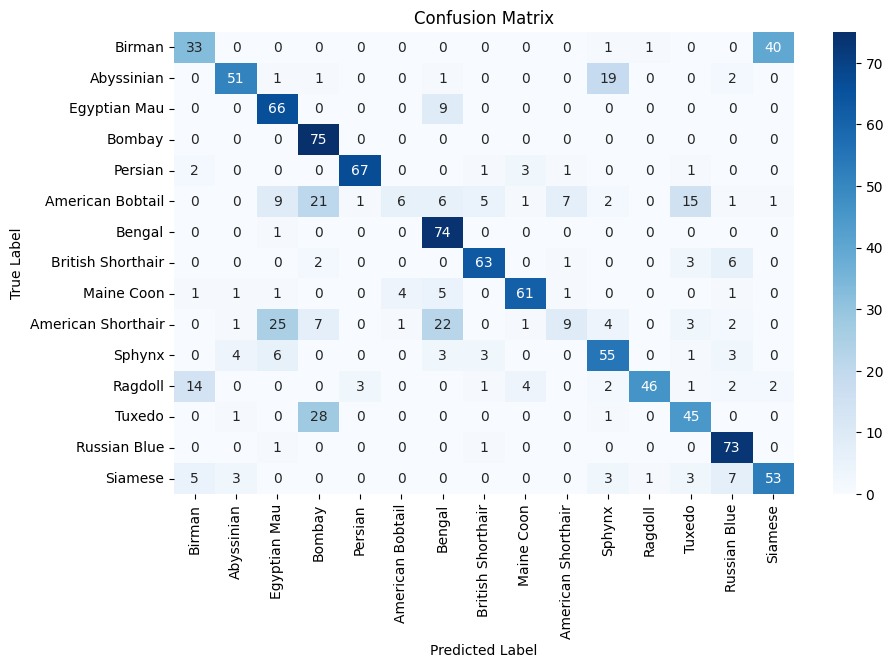

In [ ]:
# Create a dataframe with true labels and predicted labels
df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predicted_labels})

# Save the dataframe to a CSV file
df.to_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results.csv', index=False)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))

cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the CLIP model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# Load the state dictionary
state_dict = torch.load('/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model.pth')

# Load the state dictionary of the CLIP model (excluding the custom classification head)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in state_dict['clip_state_dict'].items() if k in model_dict}
model.load_state_dict(pretrained_dict)

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Load the state dictionary of the custom classification head
model.classification_head.load_state_dict(state_dict['classification_head_state_dict'])

# Set the model to evaluation mode
model.eval()

correct = []
correct_per_class = {}
image_index_correct = []
image_index_incorrect = []
true_labels_correct = []
predicted_labels_correct = []
true_labels_incorrect = []
predicted_labels_incorrect = []

text = clip.tokenize(mod_class_names).to(device)

indices = range(30)

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[mod_class_names.index(label)] == cls:
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]

                if pred_class == cls:
                    correct.append(1)
                    true_labels_correct.append(cls)
                    predicted_labels_correct.append(pred_class)
                    image_index_correct.append(index)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    true_labels_incorrect.append(cls)
                    predicted_labels_incorrect.append(pred_class)
                    image_index_incorrect.append(index)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')

currently calculating:  Birman
Accuracy on class Birman is: 1.0
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 1.0
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 1.0
currently calculating:  Bombay
Accuracy on class Bombay is: 1.0
currently calculating:  Persian
Accuracy on class Persian is: 1.0
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 1.0
currently calculating:  Bengal
Accuracy on class Bengal is: 1.0
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 1.0
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 1.0
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.0
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.5
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.75
currently calculating:  Tuxedo
Accuracy on class Tuxedo is: 0.6666666666666666
currently calculating:  Russian Blue
Accuracy on class

In [37]:
# Create a dataframe with true labels and predicted labels
df_correct = pd.DataFrame({'Image Index': image_index_correct, 'True Label': true_labels_correct, 'Predicted Label': predicted_labels_correct})
df_incorrect = pd.DataFrame({'Image Index': image_index_incorrect, 'True Label': true_labels_incorrect, 'Predicted Label': predicted_labels_incorrect})

# Save the dataframe to a CSV file
df_correct.to_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_correct_index.csv', index=False)
df_incorrect.to_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_incorrect_index.csv', index=False)

In [70]:
import os
import pandas as pd
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
from torchvision.transforms import Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np

class CatBreedDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None, normalize=True, resize_shape=(256, 256), indices=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.classes.remove('_Readme_.txt')
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # If indices are provided, use them for the dataset
        self.images = self.make_dataset(indices) if indices else self.make_dataset()

        self.transform = transform
        self.target_transform = target_transform
        self.normalize = normalize
        self.resize = Resize(resize_shape) if resize_shape is not None else None

    def make_dataset(self, indices=None):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                # label = self.class_to_idx[class_name]
                label = f"an image of a {class_name} cat"
                images.append((img_path, label))

        # If indices are provided, use them to subset the dataset
        if indices:
            images = [images[i] for i in indices]

        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = read_image(img_path, mode=ImageReadMode.RGB)

        if (self.resize or self.normalize or self.transform or self.target_transform):
            image = image.float()  # Convert to float for normalization

        if self.resize:
            image = self.resize(image)

        return image, label

In [71]:
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import transforms
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, RandomRotation, ToTensor

num_images_per_class = 375

# Create labels by repeating class names
labels = [class_name for class_name in class_names for _ in range(num_images_per_class)]

# Split the dataset into training and test sets with stratified sampling
sss_train_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss_train_test.split(range(len(dataset)), labels):
    train_indices, test_indices = train_index, test_index

# Split the training set into training and validation sets with stratified sampling
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, val_index in sss_train_val.split(train_indices, [labels[i] for i in train_indices]):
    train_indices, val_indices = train_index, val_index

# Define transformations for training
train_transform = transforms.Compose([
    RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    RandomRotation(degrees=10),
    RandomHorizontalFlip(),
])

# Apply transformations to the training set
train_dataset = CatBreedDataset(root_dir='/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1', transform=train_transform, target_transform=None, normalize=True, indices=train_indices.tolist())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create the validation dataset (no augmentations)
val_dataset = CatBreedDataset(root_dir='/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1', target_transform=None, normalize=True, indices=val_indices.tolist())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create the test dataset (no augmentations)
test_dataset = CatBreedDataset(root_dir='/content/drive/MyDrive/College/DL/Final Project/dataset/Gano-Cat-Breeds-V1_1', target_transform=None, normalize=True, indices=test_indices.tolist())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Correct Predictions:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


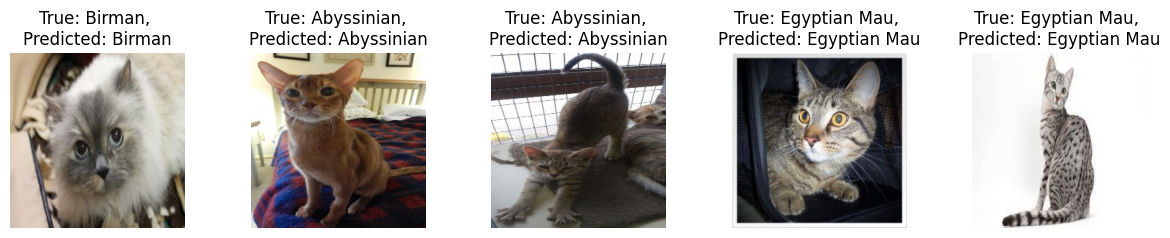

In [76]:
import matplotlib.pyplot as plt
import random

# Load the dataframe from the saved CSV file
df = pd.read_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_correct_index.csv')

# Display five images from correct predictions
print("Correct Predictions:")
plt.figure(figsize=(15, 5))
for i in range(5):
    idx = df.iloc[i]['Image Index']
    image, true_label = test_dataset[idx]
    predicted_label = df.loc[i, 'Predicted Label']
    plt.subplot(2, 5, i + 1)
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np/255
    plt.imshow(image_np)
    plt.title(f'True: {class_names[mod_class_names.index(true_label)]}, \nPredicted: {predicted_label}')
    plt.axis('off')


Inorrect Predictions:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


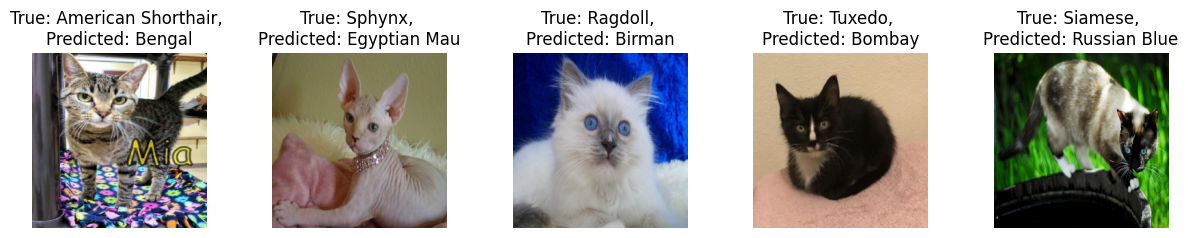

In [77]:
import matplotlib.pyplot as plt
import random

# Load the dataframe from the saved CSV file
df = pd.read_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_incorrect_index.csv')

# Display five images from correct predictions
print("Inorrect Predictions:")
plt.figure(figsize=(15, 5))
for i in range(5):
    idx = df.iloc[i]['Image Index']
    image, true_label = test_dataset[idx]
    predicted_label = df.loc[i, 'Predicted Label']
    plt.subplot(2, 5, i + 1)
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np/255
    plt.imshow(image_np)
    plt.title(f'True: {class_names[mod_class_names.index(true_label)]}, \nPredicted: {predicted_label}')
    plt.axis('off')


In [ ]:
# Display five images from incorrect predictions
print("\nIncorrect Predictions:")
for i in range(5):
    idx = random.choice(incorrect_predictions.index)
    image, true_label = dataset[idx]
    predicted_label = df.loc[idx, 'Predicted Label']

    plt.subplot(2, 5, i + 6)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')

plt.show()

## With regularization (weight decay 1e-3), lr 10^-5

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the CLIP model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# Load the state dictionary
state_dict = torch.load('/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted.pth')

# Load the state dictionary of the CLIP model (excluding the custom classification head)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in state_dict['clip_state_dict'].items() if k in model_dict}
model.load_state_dict(pretrained_dict)

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Load the state dictionary of the custom classification head
model.classification_head.load_state_dict(state_dict['classification_head_state_dict'])

# Set the model to evaluation mode
model.eval()

correct = []
correct_per_class = {}
true_labels = []
predicted_labels = []

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[mod_class_names.index(label)] == cls:
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]
                true_labels.append(cls)
                predicted_labels.append(pred_class)

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')

currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.38666666666666666
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.9466666666666667
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.6266666666666667
currently calculating:  Bombay
Accuracy on class Bombay is: 0.96
currently calculating:  Persian
Accuracy on class Persian is: 0.9333333333333333
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.16
currently calculating:  Bengal
Accuracy on class Bengal is: 0.9733333333333334
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.72
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.84
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.013333333333333334
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.38666666666666666
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.5066666666666667
currently calculating:  Tuxedo
Accura

Classification Report:
                    precision    recall  f1-score   support

            Birman     0.6636    0.9467    0.7802        75
        Abyssinian     0.5455    0.1600    0.2474        75
      Egyptian Mau     0.5000    0.0133    0.0260        75
            Bombay     0.4834    0.9733    0.6460        75
           Persian     0.4915    0.3867    0.4328        75
  American Bobtail     0.5255    0.9600    0.6792        75
            Bengal     0.9153    0.7200    0.8060        75
 British Shorthair     0.8393    0.6267    0.7176        75
        Maine Coon     0.8182    0.8400    0.8289        75
American Shorthair     0.8974    0.9333    0.9150        75
            Sphynx     0.8085    0.5067    0.6230        75
           Ragdoll     0.6239    0.9733    0.7604        75
            Tuxedo     0.5079    0.8533    0.6368        75
      Russian Blue     0.7838    0.3867    0.5179        75
           Siamese     0.6000    0.4000    0.4800        75

          accur

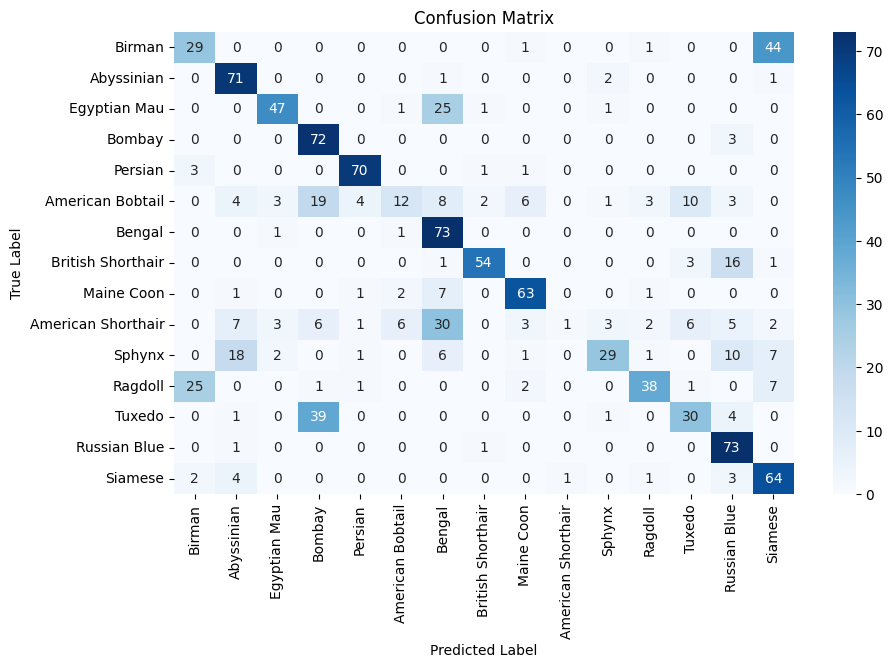

In [ ]:
# Create a dataframe with true labels and predicted labels
df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predicted_labels})

# Save the dataframe to a CSV file
df.to_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_adjusted.csv', index=False)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))

cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## With regularization (weight decay 1e-2), lr 10^-5

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the CLIP model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# Load the state dictionary
state_dict = torch.load('/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted2.pth')

# Load the state dictionary of the CLIP model (excluding the custom classification head)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in state_dict['clip_state_dict'].items() if k in model_dict}
model.load_state_dict(pretrained_dict)

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Load the state dictionary of the custom classification head
model.classification_head.load_state_dict(state_dict['classification_head_state_dict'])

# Set the model to evaluation mode
model.eval()

correct = []
correct_per_class = {}
true_labels = []
predicted_labels = []

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[mod_class_names.index(label)] == cls:
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]
                true_labels.append(cls)
                predicted_labels.append(pred_class)

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')

currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.9066666666666666
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.7733333333333333
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.7066666666666667
currently calculating:  Bombay
Accuracy on class Bombay is: 1.0
currently calculating:  Persian
Accuracy on class Persian is: 0.9333333333333333
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.05333333333333334
currently calculating:  Bengal
Accuracy on class Bengal is: 0.9866666666666667
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.8533333333333334
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.92
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.0
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.52
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.48
currently calculating:  Tuxedo
Accuracy on class Tuxedo 

Classification Report:
                    precision    recall  f1-score   support

            Birman     0.8406    0.7733    0.8056        75
        Abyssinian     0.5714    0.0533    0.0976        75
      Egyptian Mau     0.0000    0.0000    0.0000        75
            Bombay     0.5068    0.9867    0.6697        75
           Persian     0.5354    0.9067    0.6733        75
  American Bobtail     0.6250    1.0000    0.7692        75
            Bengal     0.8889    0.8533    0.8707        75
 British Shorthair     0.7067    0.7067    0.7067        75
        Maine Coon     0.6389    0.9200    0.7541        75
American Shorthair     0.8046    0.9333    0.8642        75
            Sphynx     0.7059    0.4800    0.5714        75
           Ragdoll     0.9041    0.8800    0.8919        75
            Tuxedo     0.7742    0.6400    0.7007        75
      Russian Blue     0.6610    0.5200    0.5821        75
           Siamese     0.6970    0.6133    0.6525        75

          accur

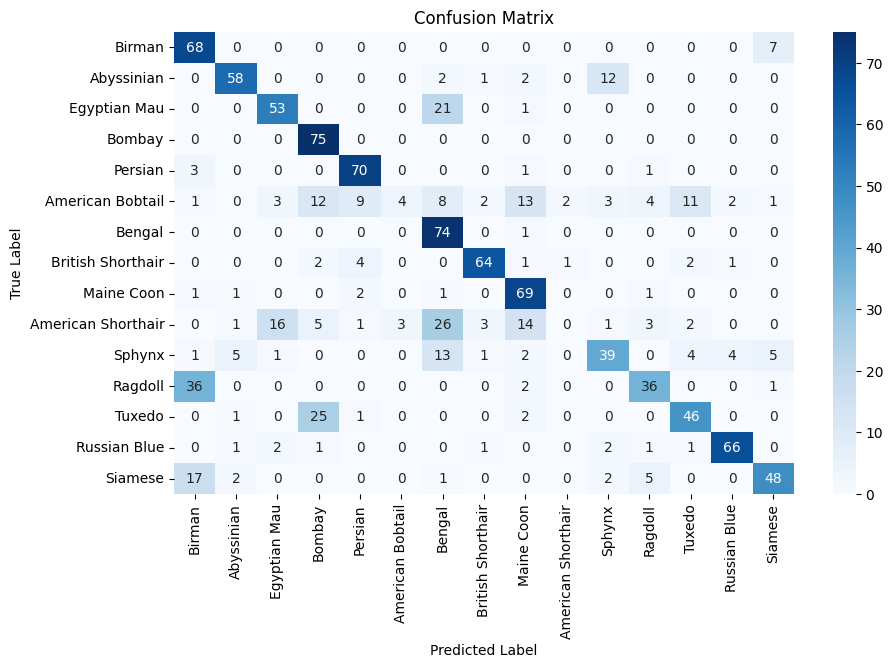

In [ ]:
# Create a dataframe with true labels and predicted labels
df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predicted_labels})

# Save the dataframe to a CSV file
df.to_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_adjusted2.csv', index=False)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))

cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## without regularization, lr 10^-6

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the CLIP model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# Load the state dictionary
state_dict = torch.load('/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted5.pth')

# Load the state dictionary of the CLIP model (excluding the custom classification head)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in state_dict['clip_state_dict'].items() if k in model_dict}
model.load_state_dict(pretrained_dict)

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Load the state dictionary of the custom classification head
model.classification_head.load_state_dict(state_dict['classification_head_state_dict'])

# Set the model to evaluation mode
model.eval()

correct = []
correct_per_class = {}
true_labels = []
predicted_labels = []

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[mod_class_names.index(label)] == cls:
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]
                true_labels.append(cls)
                predicted_labels.append(pred_class)

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')

currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.5466666666666666
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.6266666666666667
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.6666666666666666
currently calculating:  Bombay
Accuracy on class Bombay is: 0.9866666666666667
currently calculating:  Persian
Accuracy on class Persian is: 0.8533333333333334
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.06666666666666667
currently calculating:  Bengal
Accuracy on class Bengal is: 0.9333333333333333
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.4
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.7333333333333333
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.05333333333333334
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.7066666666666667
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.48
currently ca

Classification Report:
                    precision    recall  f1-score   support

            Birman     0.8103    0.6267    0.7068        75
        Abyssinian     0.1724    0.0667    0.0962        75
      Egyptian Mau     0.3077    0.0533    0.0909        75
            Bombay     0.5185    0.9333    0.6667        75
           Persian     0.5062    0.5467    0.5256        75
  American Bobtail     0.6066    0.9867    0.7513        75
            Bengal     0.7895    0.4000    0.5310        75
 British Shorthair     0.7143    0.6667    0.6897        75
        Maine Coon     0.7432    0.7333    0.7383        75
American Shorthair     0.7711    0.8533    0.8101        75
            Sphynx     0.6316    0.4800    0.5455        75
           Ragdoll     0.6058    0.8400    0.7039        75
            Tuxedo     0.5565    0.8533    0.6737        75
      Russian Blue     0.6543    0.7067    0.6795        75
           Siamese     0.7077    0.6133    0.6571        75

          accur

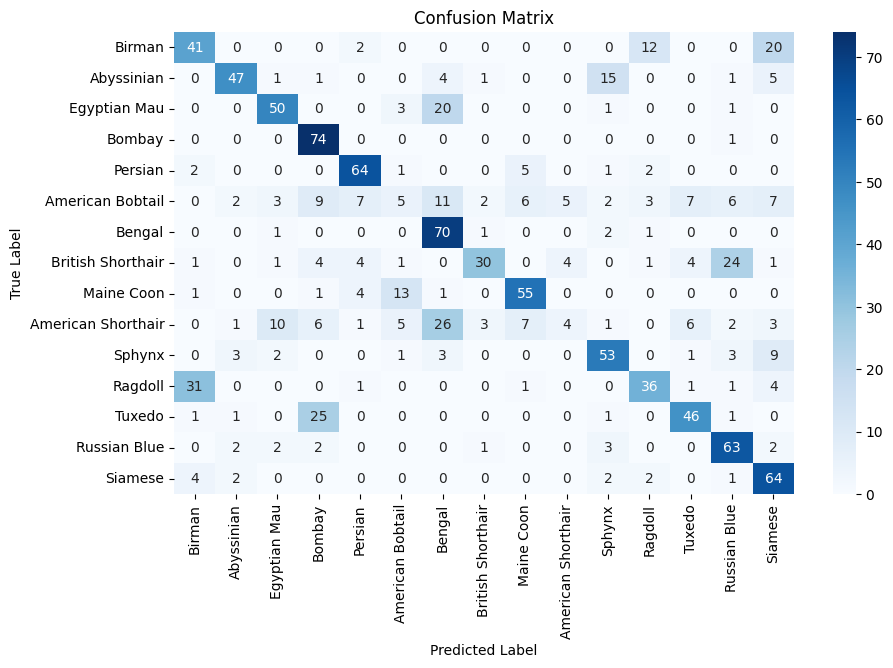

In [ ]:
# Create a dataframe with true labels and predicted labels
df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predicted_labels})

# Save the dataframe to a CSV file
df.to_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_adjusted5.csv', index=False)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))

cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## with regularization (weight decay 1e-2), lr 10^-6

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the CLIP model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# Load the state dictionary
state_dict = torch.load('/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted3.pth')

# Load the state dictionary of the CLIP model (excluding the custom classification head)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in state_dict['clip_state_dict'].items() if k in model_dict}
model.load_state_dict(pretrained_dict)

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Load the state dictionary of the custom classification head
model.classification_head.load_state_dict(state_dict['classification_head_state_dict'])

# Set the model to evaluation mode
model.eval()

correct = []
correct_per_class = {}
true_labels = []
predicted_labels = []

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[mod_class_names.index(label)] == cls:
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]
                true_labels.append(cls)
                predicted_labels.append(pred_class)

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')

currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.64
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.68
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.7066666666666667
currently calculating:  Bombay
Accuracy on class Bombay is: 0.9866666666666667
currently calculating:  Persian
Accuracy on class Persian is: 0.8533333333333334
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.12
currently calculating:  Bengal
Accuracy on class Bengal is: 0.92
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.26666666666666666
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.7733333333333333
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.10666666666666667
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.7333333333333333
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.49333333333333335
currently calculating:  Tuxedo
Accurac

Classification Report:
                    precision    recall  f1-score   support

            Birman     0.8644    0.6800    0.7612        75
        Abyssinian     0.2727    0.1200    0.1667        75
      Egyptian Mau     0.3636    0.1067    0.1649        75
            Bombay     0.5656    0.9200    0.7005        75
           Persian     0.6316    0.6400    0.6358        75
  American Bobtail     0.6607    0.9867    0.7914        75
            Bengal     0.8000    0.2667    0.4000        75
 British Shorthair     0.7361    0.7067    0.7211        75
        Maine Coon     0.6304    0.7733    0.6946        75
American Shorthair     0.8421    0.8533    0.8477        75
            Sphynx     0.6981    0.4933    0.5781        75
           Ragdoll     0.5981    0.8533    0.7033        75
            Tuxedo     0.5667    0.9067    0.6974        75
      Russian Blue     0.6790    0.7333    0.7051        75
           Siamese     0.6933    0.6933    0.6933        75

          accur

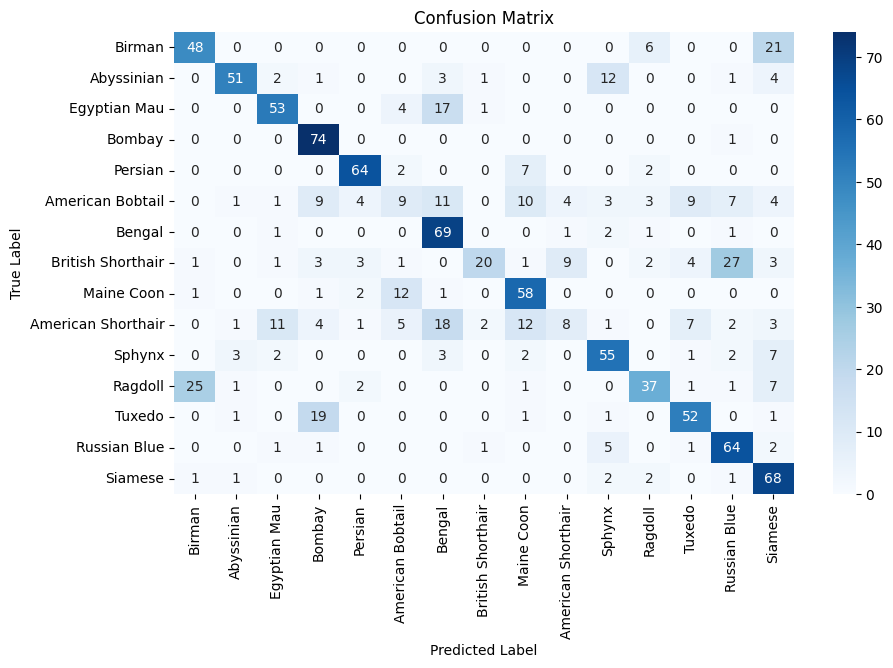

In [ ]:
# Create a dataframe with true labels and predicted labels
df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predicted_labels})

# Save the dataframe to a CSV file
df.to_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_adjusted3.csv', index=False)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))

cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## with regularization (weight decay 1e-1), lr 10^-6

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the CLIP model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# Load the state dictionary
state_dict = torch.load('/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted4.pth')

# Load the state dictionary of the CLIP model (excluding the custom classification head)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in state_dict['clip_state_dict'].items() if k in model_dict}
model.load_state_dict(pretrained_dict)

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Load the state dictionary of the custom classification head
model.classification_head.load_state_dict(state_dict['classification_head_state_dict'])

# Set the model to evaluation mode
model.eval()

correct = []
correct_per_class = {}
true_labels = []
predicted_labels = []

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[mod_class_names.index(label)] == cls:
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]
                true_labels.append(cls)
                predicted_labels.append(pred_class)

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')

currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.49333333333333335
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.72
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.6666666666666666
currently calculating:  Bombay
Accuracy on class Bombay is: 0.9866666666666667
currently calculating:  Persian
Accuracy on class Persian is: 0.8533333333333334
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.13333333333333333
currently calculating:  Bengal
Accuracy on class Bengal is: 0.9333333333333333
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.4266666666666667
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.6
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.08
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.68
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.5466666666666666
currently calculating:  Tuxedo
Accuracy 

Classification Report:
                    precision    recall  f1-score   support

            Birman     0.7606    0.7200    0.7397        75
        Abyssinian     0.2041    0.1333    0.1613        75
      Egyptian Mau     0.2857    0.0800    0.1250        75
            Bombay     0.5469    0.9333    0.6897        75
           Persian     0.5873    0.4933    0.5362        75
  American Bobtail     0.6491    0.9867    0.7831        75
            Bengal     0.8421    0.4267    0.5664        75
 British Shorthair     0.7246    0.6667    0.6944        75
        Maine Coon     0.7895    0.6000    0.6818        75
American Shorthair     0.9014    0.8533    0.8767        75
            Sphynx     0.6406    0.5467    0.5899        75
           Ragdoll     0.6742    0.8000    0.7317        75
            Tuxedo     0.5036    0.9200    0.6509        75
      Russian Blue     0.6623    0.6800    0.6711        75
           Siamese     0.6883    0.7067    0.6974        75

          accur

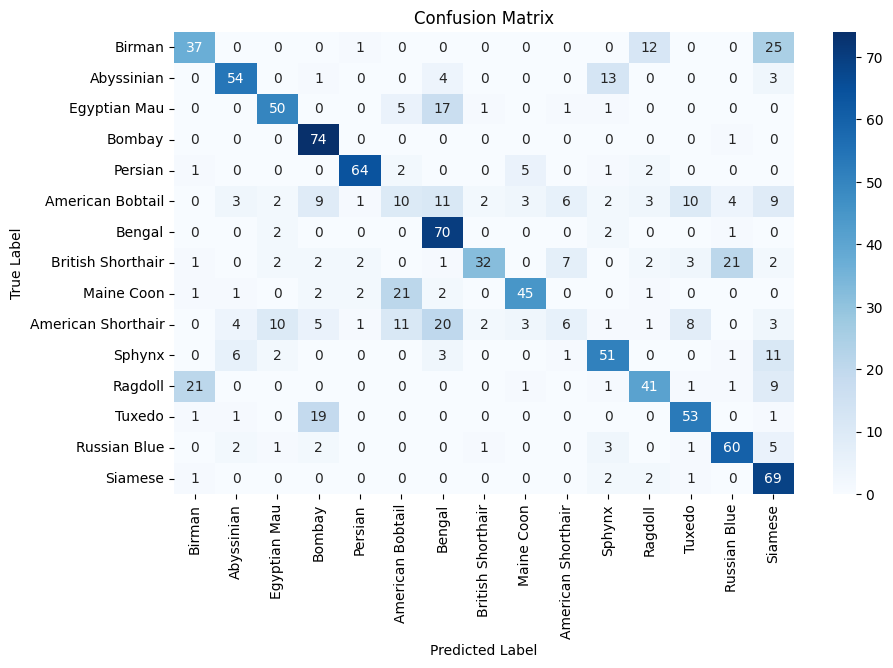

In [ ]:
# Create a dataframe with true labels and predicted labels
df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predicted_labels})

# Save the dataframe to a CSV file
df.to_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_adjusted4.csv', index=False)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))

cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## without regularization, lr 10^-7

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the CLIP model
model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# Load the state dictionary
state_dict = torch.load('/content/drive/MyDrive/College/DL/Final Project/supervised_clip_model_adjusted6.pth')

# Load the state dictionary of the CLIP model (excluding the custom classification head)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in state_dict['clip_state_dict'].items() if k in model_dict}
model.load_state_dict(pretrained_dict)

# Modify the classification head
num_classes = len(mod_class_names)
model.classification_head = torch.nn.Linear(512, num_classes).to(device)

# Load the state dictionary of the custom classification head
model.classification_head.load_state_dict(state_dict['classification_head_state_dict'])

# Set the model to evaluation mode
model.eval()

correct = []
correct_per_class = {}
true_labels = []
predicted_labels = []

text = clip.tokenize(mod_class_names).to(device)

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[mod_class_names.index(label)] == cls:
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                text_features = model.encode_text(text)

                logits_per_image, logits_per_text = model(image, text)

                probs = logits_per_image.softmax(dim=-1).cpu().numpy()

                pred_idx = argmax(list(probs)[0])
                pred_class = class_names[pred_idx]
                true_labels.append(cls)
                predicted_labels.append(pred_class)

                if pred_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')

currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.4266666666666667
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.52
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.6533333333333333
currently calculating:  Bombay
Accuracy on class Bombay is: 0.84
currently calculating:  Persian
Accuracy on class Persian is: 0.5333333333333333
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.21333333333333335
currently calculating:  Bengal
Accuracy on class Bengal is: 0.8133333333333334
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.09333333333333334
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.52
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.0
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.64
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.48
currently calculating:  Tuxedo
Accuracy on class Tuxedo is: 0.626666

Classification Report:
                    precision    recall  f1-score   support

            Birman     0.7222    0.5200    0.6047        75
        Abyssinian     0.2000    0.2133    0.2065        75
      Egyptian Mau     0.0000    0.0000    0.0000        75
            Bombay     0.4803    0.8133    0.6040        75
           Persian     0.5714    0.4267    0.4885        75
  American Bobtail     0.6300    0.8400    0.7200        75
            Bengal     0.7000    0.0933    0.1647        75
 British Shorthair     0.4949    0.6533    0.5632        75
        Maine Coon     0.4643    0.5200    0.4906        75
American Shorthair     0.8000    0.5333    0.6400        75
            Sphynx     0.5143    0.4800    0.4966        75
           Ragdoll     0.5102    0.6667    0.5780        75
            Tuxedo     0.4012    0.8667    0.5485        75
      Russian Blue     0.6761    0.6400    0.6575        75
           Siamese     0.7705    0.6267    0.6912        75

          accur

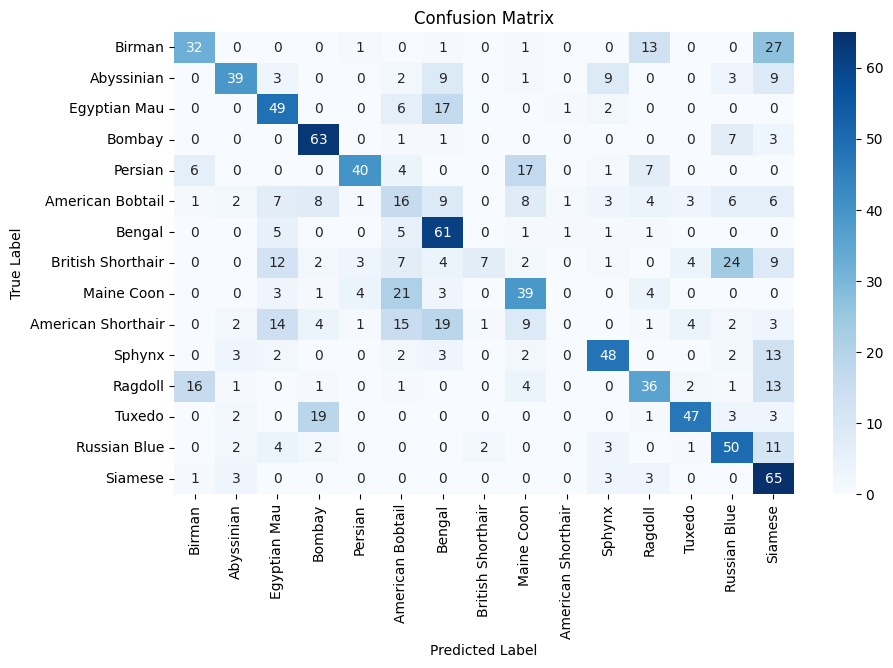

In [ ]:
# Create a dataframe with true labels and predicted labels
df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predicted_labels})

# Save the dataframe to a CSV file
df.to_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_adjusted6.csv', index=False)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))

cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# EfficientNet B0

In [ ]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9ab0311a2de0f210c2ffcba4d111a4ab158d32ded7c9c668950e4613f2a1b993
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


## Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNet.from_pretrained("efficientnet-b0", num_classes=len(class_names))
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0

    with tqdm(train_loader, unit="batch") as train_bar:
        for images, labels in train_bar:
            images = images.to(device)
            labels = torch.tensor([mod_class_names.index(label) for label in labels]).to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

    # Validation loop
    model.eval()
    validation_loss = 0.0
    correct_val = 0
    total_val = 0

    with tqdm(val_loader, unit="batch") as val_bar:
        with torch.no_grad():
            for images, labels in val_bar:
                images = images.to(device)
                labels = torch.tensor([mod_class_names.index(label) for label in labels]).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

    # Calculate average validation loss
    average_validation_loss = validation_loss / len(val_loader)

    # Print metrics at the end of the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {loss.item():.4f}, Training Accuracy: {correct_train / total_train * 100:.2f}%, "
          f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {correct_val / total_val * 100:.2f}%")

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/College/DL/Final Project/efficientnet_model.pth')

Loaded pretrained weights for efficientnet-b0


  0%|          | 0/127 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 15/15 [02:00<00:00,  8.05s/batch]


Epoch 1/20, Training Loss: 2.9553, Training Accuracy: 12.27%, Validation Loss: 2.6097, Validation Accuracy: 21.11%


100%|██████████| 15/15 [00:06<00:00,  2.24batch/s]


Epoch 2/20, Training Loss: 2.8633, Training Accuracy: 24.67%, Validation Loss: 2.4484, Validation Accuracy: 33.33%


100%|██████████| 15/15 [00:06<00:00,  2.47batch/s]


Epoch 3/20, Training Loss: 2.7537, Training Accuracy: 34.74%, Validation Loss: 2.2745, Validation Accuracy: 40.00%


100%|██████████| 15/15 [00:06<00:00,  2.49batch/s]


Epoch 4/20, Training Loss: 2.6301, Training Accuracy: 43.65%, Validation Loss: 2.0816, Validation Accuracy: 45.33%


100%|██████████| 15/15 [00:06<00:00,  2.48batch/s]


Epoch 5/20, Training Loss: 2.5472, Training Accuracy: 49.60%, Validation Loss: 1.8934, Validation Accuracy: 49.56%


100%|██████████| 15/15 [00:06<00:00,  2.19batch/s]


Epoch 6/20, Training Loss: 2.4516, Training Accuracy: 53.06%, Validation Loss: 1.7199, Validation Accuracy: 53.78%


100%|██████████| 15/15 [00:07<00:00,  2.00batch/s]


Epoch 7/20, Training Loss: 2.3759, Training Accuracy: 56.67%, Validation Loss: 1.5712, Validation Accuracy: 56.00%


100%|██████████| 15/15 [00:06<00:00,  2.23batch/s]


Epoch 8/20, Training Loss: 2.3504, Training Accuracy: 58.74%, Validation Loss: 1.4613, Validation Accuracy: 57.33%


100%|██████████| 15/15 [00:06<00:00,  2.49batch/s]


Epoch 9/20, Training Loss: 2.3291, Training Accuracy: 60.07%, Validation Loss: 1.3738, Validation Accuracy: 58.22%


100%|██████████| 15/15 [00:05<00:00,  2.50batch/s]


Epoch 10/20, Training Loss: 2.2947, Training Accuracy: 61.01%, Validation Loss: 1.2991, Validation Accuracy: 60.89%


100%|██████████| 15/15 [00:05<00:00,  2.54batch/s]


Epoch 11/20, Training Loss: 2.2563, Training Accuracy: 61.60%, Validation Loss: 1.2418, Validation Accuracy: 62.67%


100%|██████████| 15/15 [00:05<00:00,  2.53batch/s]


Epoch 12/20, Training Loss: 2.2828, Training Accuracy: 63.43%, Validation Loss: 1.1967, Validation Accuracy: 64.22%


100%|██████████| 15/15 [00:06<00:00,  2.41batch/s]


Epoch 13/20, Training Loss: 2.2601, Training Accuracy: 64.54%, Validation Loss: 1.1539, Validation Accuracy: 65.78%


100%|██████████| 15/15 [00:06<00:00,  2.25batch/s]


Epoch 14/20, Training Loss: 2.2446, Training Accuracy: 66.84%, Validation Loss: 1.1174, Validation Accuracy: 67.11%


100%|██████████| 15/15 [00:07<00:00,  1.93batch/s]


Epoch 15/20, Training Loss: 2.2659, Training Accuracy: 68.47%, Validation Loss: 1.0884, Validation Accuracy: 67.11%


100%|██████████| 15/15 [00:07<00:00,  1.93batch/s]


Epoch 16/20, Training Loss: 2.3119, Training Accuracy: 68.05%, Validation Loss: 1.0655, Validation Accuracy: 66.89%


100%|██████████| 15/15 [00:07<00:00,  2.00batch/s]


Epoch 17/20, Training Loss: 2.3140, Training Accuracy: 70.20%, Validation Loss: 1.0399, Validation Accuracy: 67.11%


100%|██████████| 15/15 [00:06<00:00,  2.21batch/s]


Epoch 18/20, Training Loss: 2.2847, Training Accuracy: 71.26%, Validation Loss: 1.0187, Validation Accuracy: 67.78%


100%|██████████| 15/15 [00:07<00:00,  1.95batch/s]


Epoch 19/20, Training Loss: 2.3034, Training Accuracy: 70.54%, Validation Loss: 1.0016, Validation Accuracy: 68.44%


100%|██████████| 15/15 [00:06<00:00,  2.41batch/s]

Epoch 20/20, Training Loss: 2.3238, Training Accuracy: 72.49%, Validation Loss: 0.9845, Validation Accuracy: 68.67%


## Testing

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNet.from_pretrained("efficientnet-b0", num_classes=len(class_names))
model = model.to(device)

# Load the state dictionary
state_dict = torch.load('/content/drive/MyDrive/College/DL/Final Project/efficientnet_model.pth')

# Load the state dictionary of the CLIP model (excluding the custom classification head)
# model_dict = model.state_dict()
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

correct = []
correct_per_class = {}
true_labels = []
predicted_labels = []

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[mod_class_names.index(label)] == cls:
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                image = image.to(device)

                outputs = model(image)
                _, predict = torch.max(outputs.data, 1)
                predict = predict.cpu().numpy()
                predict_class = class_names[predict[0]]
                true_labels.append(cls)
                predicted_labels.append(predict_class)

                if predict_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')

Loaded pretrained weights for efficientnet-b0
currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.8666666666666667
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.88
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.8933333333333333
currently calculating:  Bombay
Accuracy on class Bombay is: 0.9866666666666667
currently calculating:  Persian
Accuracy on class Persian is: 0.8933333333333333
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.29333333333333333
currently calculating:  Bengal
Accuracy on class Bengal is: 0.8133333333333334
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.6666666666666666
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.8933333333333333
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.41333333333333333
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.0
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.6933333333333334
currently ca

Classification Report:
                    precision    recall  f1-score   support

            Birman     0.4521    0.8800    0.5973        75
        Abyssinian     0.3492    0.2933    0.3188        75
      Egyptian Mau     0.5082    0.4133    0.4559        75
            Bombay     0.7821    0.8133    0.7974        75
           Persian     0.4745    0.8667    0.6132        75
  American Bobtail     0.5362    0.9867    0.6948        75
            Bengal     0.7042    0.6667    0.6849        75
 British Shorthair     0.6442    0.8933    0.7486        75
        Maine Coon     0.6700    0.8933    0.7657        75
American Shorthair     0.9178    0.8933    0.9054        75
            Sphynx     0.7761    0.6933    0.7324        75
           Ragdoll     0.6897    0.8000    0.7407        75
            Tuxedo     0.0000    0.0000    0.0000        75
      Russian Blue     0.0000    0.0000    0.0000        75
           Siamese     0.0000    0.0000    0.0000        75

          accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


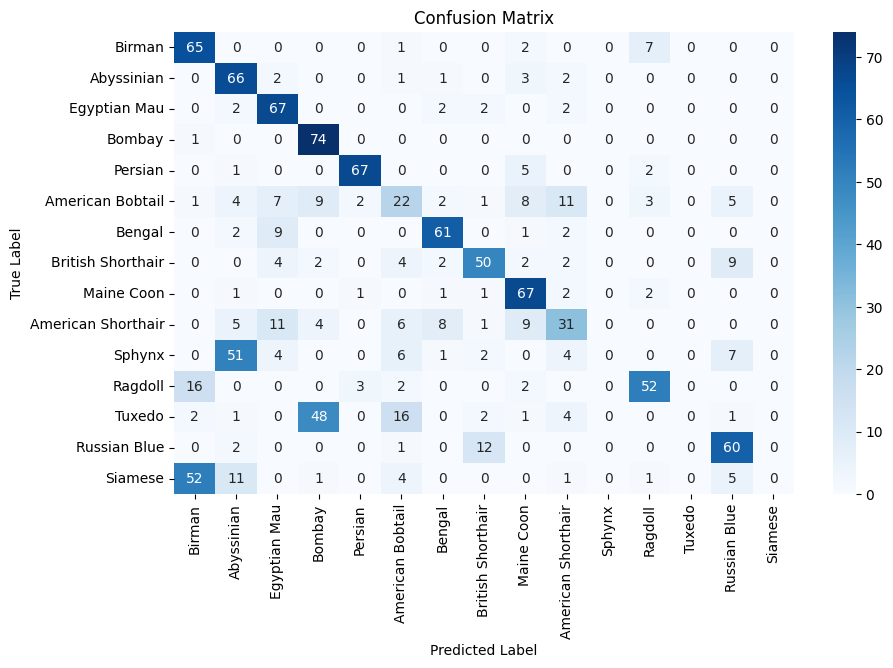

In [ ]:
# Create a dataframe with true labels and predicted labels
df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predicted_labels})

# Save the dataframe to a CSV file
df.to_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_efficientnet.csv', index=False)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))

cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ResNet

## Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# Assume you have class_names, mod_class_names, train_loader, and val_loader defined

# Use a pre-trained ResNet model
model = resnet.resnet18(pretrained=True)
# Modify the output layer to match the number of your classes
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0

    with tqdm(train_loader, unit="batch") as train_bar:
        for images, labels in train_bar:
            images = images.to(device)
            labels = torch.tensor([mod_class_names.index(label) for label in labels]).to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

    # Validation loop
    model.eval()
    validation_loss = 0.0
    correct_val = 0
    total_val = 0

    with tqdm(val_loader, unit="batch") as val_bar:
        with torch.no_grad():
            for images, labels in val_bar:
                images = images.to(device)
                labels = torch.tensor([mod_class_names.index(label) for label in labels]).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

    # Calculate average validation loss
    average_validation_loss = validation_loss / len(val_loader)

    # Print metrics at the end of the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {loss.item():.4f}, Training Accuracy: {correct_train / total_train * 100:.2f}%, "
          f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {correct_val / total_val * 100:.2f}%")

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/College/DL/Final Project/resnet_model.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/127 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warnin

Epoch 1/20, Training Loss: 2.8857, Training Accuracy: 20.67%, Validation Loss: 2.1410, Validation Accuracy: 32.89%


100%|██████████| 15/15 [00:05<00:00,  2.90batch/s]


Epoch 2/20, Training Loss: 2.6491, Training Accuracy: 43.19%, Validation Loss: 1.7108, Validation Accuracy: 50.00%


100%|██████████| 15/15 [00:05<00:00,  2.94batch/s]


Epoch 3/20, Training Loss: 2.4772, Training Accuracy: 54.52%, Validation Loss: 1.4933, Validation Accuracy: 54.22%


100%|██████████| 15/15 [00:05<00:00,  2.94batch/s]


Epoch 4/20, Training Loss: 2.2689, Training Accuracy: 60.30%, Validation Loss: 1.3521, Validation Accuracy: 58.00%


100%|██████████| 15/15 [00:05<00:00,  2.74batch/s]


Epoch 5/20, Training Loss: 2.1031, Training Accuracy: 62.89%, Validation Loss: 1.2630, Validation Accuracy: 59.56%


100%|██████████| 15/15 [00:06<00:00,  2.42batch/s]


Epoch 6/20, Training Loss: 2.0102, Training Accuracy: 65.93%, Validation Loss: 1.1960, Validation Accuracy: 61.56%


100%|██████████| 15/15 [00:06<00:00,  2.27batch/s]


Epoch 7/20, Training Loss: 1.7501, Training Accuracy: 68.10%, Validation Loss: 1.1307, Validation Accuracy: 61.33%


100%|██████████| 15/15 [00:06<00:00,  2.50batch/s]


Epoch 8/20, Training Loss: 1.9772, Training Accuracy: 69.75%, Validation Loss: 1.1123, Validation Accuracy: 64.89%


100%|██████████| 15/15 [00:06<00:00,  2.46batch/s]


Epoch 9/20, Training Loss: 1.7160, Training Accuracy: 71.41%, Validation Loss: 1.0587, Validation Accuracy: 66.67%


100%|██████████| 15/15 [00:05<00:00,  2.97batch/s]


Epoch 10/20, Training Loss: 1.7000, Training Accuracy: 74.10%, Validation Loss: 1.0352, Validation Accuracy: 65.33%


100%|██████████| 15/15 [00:05<00:00,  2.92batch/s]


Epoch 11/20, Training Loss: 1.7269, Training Accuracy: 75.46%, Validation Loss: 1.0117, Validation Accuracy: 66.89%


100%|██████████| 15/15 [00:05<00:00,  2.80batch/s]


Epoch 12/20, Training Loss: 1.7770, Training Accuracy: 77.51%, Validation Loss: 0.9978, Validation Accuracy: 67.78%


100%|██████████| 15/15 [00:06<00:00,  2.33batch/s]


Epoch 13/20, Training Loss: 1.7276, Training Accuracy: 78.00%, Validation Loss: 0.9868, Validation Accuracy: 66.89%


100%|██████████| 15/15 [00:05<00:00,  2.70batch/s]


Epoch 14/20, Training Loss: 1.7147, Training Accuracy: 79.95%, Validation Loss: 0.9719, Validation Accuracy: 67.78%


100%|██████████| 15/15 [00:05<00:00,  2.94batch/s]


Epoch 15/20, Training Loss: 1.7591, Training Accuracy: 81.75%, Validation Loss: 0.9782, Validation Accuracy: 67.33%


100%|██████████| 15/15 [00:05<00:00,  2.95batch/s]


Epoch 16/20, Training Loss: 1.8440, Training Accuracy: 82.40%, Validation Loss: 0.9643, Validation Accuracy: 68.44%


100%|██████████| 15/15 [00:05<00:00,  2.96batch/s]


Epoch 17/20, Training Loss: 1.7997, Training Accuracy: 83.48%, Validation Loss: 0.9621, Validation Accuracy: 68.00%


100%|██████████| 15/15 [00:05<00:00,  2.72batch/s]


Epoch 18/20, Training Loss: 1.7738, Training Accuracy: 85.09%, Validation Loss: 0.9471, Validation Accuracy: 67.56%


100%|██████████| 15/15 [00:06<00:00,  2.33batch/s]


Epoch 19/20, Training Loss: 1.8051, Training Accuracy: 85.90%, Validation Loss: 0.9491, Validation Accuracy: 68.67%


100%|██████████| 15/15 [00:06<00:00,  2.33batch/s]

Epoch 20/20, Training Loss: 1.6451, Training Accuracy: 87.65%, Validation Loss: 0.9336, Validation Accuracy: 68.22%


## Testing

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet.resnet18(pretrained=True)
# Modify the output layer to match the number of your classes
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# Load the state dictionary
state_dict = torch.load('/content/drive/MyDrive/College/DL/Final Project/resnet_model.pth')

# Load the state dictionary of the CLIP model (excluding the custom classification head)
# model_dict = model.state_dict()
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

correct = []
correct_per_class = {}
true_labels = []
predicted_labels = []

indices = range(len(test_dataset))

for cls in class_names:
    correct_per_class[cls] = []  # Initialize an empty list for each class
    print("currently calculating: ", cls)

    for index in indices:
        image, label = test_dataset[index]
        if class_names[mod_class_names.index(label)] == cls:
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():
                image = image.to(device)

                outputs = model(image)
                _, predict = torch.max(outputs.data, 1)
                predict = predict.cpu().numpy()
                predict_class = class_names[predict[0]]
                true_labels.append(cls)
                predicted_labels.append(predict_class)

                if predict_class == cls:
                    correct.append(1)
                    correct_per_class[cls].append(1)
                else:
                    correct.append(0)
                    correct_per_class[cls].append(0)

    if len(correct_per_class[cls]) != 0:
      accuracy = sum(correct_per_class[cls]) / len(correct_per_class[cls])
      print(f'Accuracy on class {cls} is: {accuracy}')

total_accuracy = sum(correct) / len(correct)
print(f'Accuracy on all is: {total_accuracy}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


currently calculating:  Birman


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy on class Birman is: 0.9466666666666667
currently calculating:  Abyssinian
Accuracy on class Abyssinian is: 0.96
currently calculating:  Egyptian Mau
Accuracy on class Egyptian Mau is: 0.92
currently calculating:  Bombay
Accuracy on class Bombay is: 0.96
currently calculating:  Persian
Accuracy on class Persian is: 0.9466666666666667
currently calculating:  American Bobtail
Accuracy on class American Bobtail is: 0.6666666666666666
currently calculating:  Bengal
Accuracy on class Bengal is: 0.92
currently calculating:  British Shorthair
Accuracy on class British Shorthair is: 0.9333333333333333
currently calculating:  Maine Coon
Accuracy on class Maine Coon is: 0.9333333333333333
currently calculating:  American Shorthair
Accuracy on class American Shorthair is: 0.7466666666666667
currently calculating:  Sphynx
Accuracy on class Sphynx is: 0.0
currently calculating:  Ragdoll
Accuracy on class Ragdoll is: 0.88
currently calculating:  Tuxedo
Accuracy on class Tuxedo is: 0.0
curren

Classification Report:
                    precision    recall  f1-score   support

            Birman     0.5854    0.9600    0.7273        75
        Abyssinian     0.5556    0.6667    0.6061        75
      Egyptian Mau     0.6292    0.7467    0.6829        75
            Bombay     0.8734    0.9200    0.8961        75
           Persian     0.5071    0.9467    0.6605        75
  American Bobtail     0.6729    0.9600    0.7912        75
            Bengal     0.7527    0.9333    0.8333        75
 British Shorthair     0.8023    0.9200    0.8571        75
        Maine Coon     0.8333    0.9333    0.8805        75
American Shorthair     0.9467    0.9467    0.9467        75
            Sphynx     0.8049    0.8800    0.8408        75
           Ragdoll     0.8701    0.8933    0.8816        75
            Tuxedo     0.0000    0.0000    0.0000        75
      Russian Blue     0.0000    0.0000    0.0000        75
           Siamese     0.0000    0.0000    0.0000        75

          accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


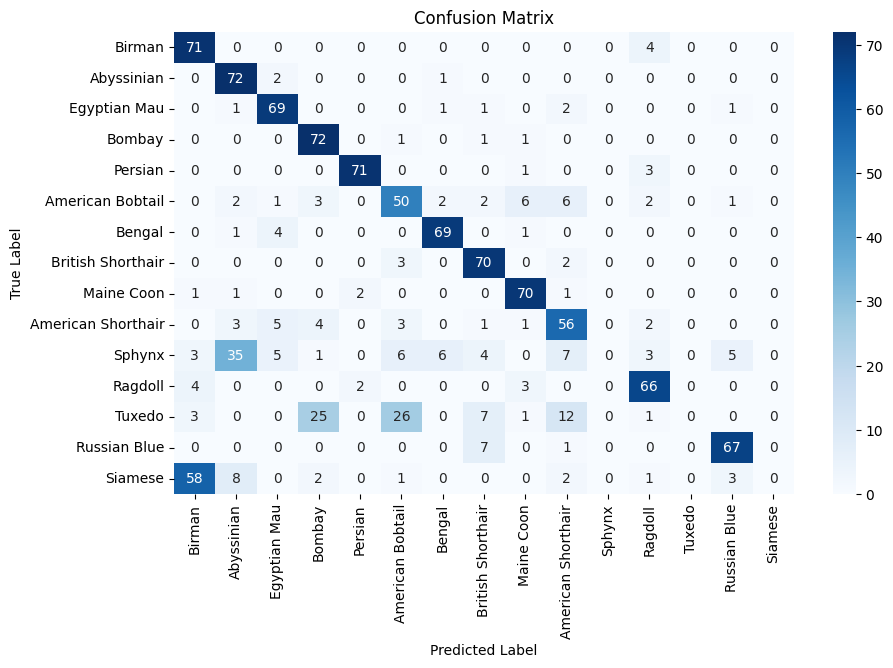

In [ ]:
# Create a dataframe with true labels and predicted labels
df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predicted_labels})

# Save the dataframe to a CSV file
df.to_csv('/content/drive/MyDrive/College/DL/Final Project/classification_results_resnet.csv', index=False)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))

cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()